# Librerías

In [211]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from concurrent.futures import ThreadPoolExecutor, as_completed
from matplotlib.patches import FancyBboxPatch
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches


import athena_utils as athena
import openia_script as ia

In [212]:
projects_id= 72

# Querys

In [213]:
def ejecutar_queries_paralelo(queries_dict, max_workers=5):
    """
    Ejecuta múltiples queries de Athena en paralelo.
    
    Args:
        queries_dict (dict): Diccionario donde la clave es el nombre identificador 
                            y el valor es la query SQL
                            Ejemplo: {'cancelaciones': query1, 'asistencias': query2}
        max_workers (int): Número máximo de threads paralelos (default: 5)
    
    Returns:
        dict: Diccionario con los DataFrames resultantes
              Ejemplo: {'cancelaciones': df1, 'asistencias': df2}
    """
    results = {}
    errors = {}
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Enviar todas las queries en paralelo
        futures = {
            executor.submit(athena.run_athena_query_auto, query, name): name 
            for name, query in queries_dict.items()
        }
        
        # Recoger resultados según vayan terminando
        for future in as_completed(futures):
            query_name = futures[future]
            try:
                df = future.result()
                results[query_name] = df
                print(f"✅ {query_name}: {len(df)} filas obtenidas")
            except Exception as e:
                errors[query_name] = str(e)
                print(f"❌ {query_name}: Error - {e}")
    
    # Reportar resumen
    print(f"\n📊 Resumen: {len(results)}/{len(queries_dict)} queries completadas exitosamente")
    
    if errors:
        print(f"⚠️  Queries con error: {list(errors.keys())}")
    
    return results

In [214]:
query_proyectos=f'''

SELECT 
    p.id AS proyecto_id,
    p.name AS proyecto_nombre,
    p.status AS estado,
    p.type AS tipo_canal,
    p.mode AS modalidad,
    p.operation_type AS tipo_operacion,
    p.complex_level AS nivel_complejidad,
    p.format AS formato,
    p.winning_date AS fecha_ganancia,
    p.operative_start_date AS fecha_inicio_operativo,
    p.operative_end_date AS fecha_fin_operativo,
    p.description AS descripcion,
    p.comment AS comentario,
    p.gender_focus AS enfoque_genero,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS organizaciones,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT o.organization_type), ', ') AS tipos_organizacion,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT c.name), ', ') AS paises,
    ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS tipos_programa
FROM 
    datalake.projects p
    LEFT JOIN datalake.project_organization_association poa ON p.id = poa.project_id
    LEFT JOIN datalake.organizations o ON poa.organization_id = o.id
    LEFT JOIN datalake.countries c ON o.country_id = c.id
    LEFT JOIN datalake.project_program_type_association ppta ON p.id = ppta.project_id
    LEFT JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
WHERE 
    p.id IN ({projects_id})
    
GROUP BY 
    p.id,
    p.name,
    p.status,
    p.type,
    p.mode,
    p.operation_type,
    p.complex_level,
    p.format,
    p.winning_date,
    p.operative_start_date,
    p.operative_end_date,
    p.seat_sold,
    p.description,
    p.comment,
    p.gender_focus
ORDER BY 
    p.id

'''

In [215]:
query_cancelaciones= f'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.name), ', ') AS org_names
    FROM datalake.project_organization_association poa
    JOIN datalake.organizations o ON poa.organization_id = o.id
    GROUP BY poa.project_id
),
cte_ProgramType AS (
    SELECT
        ppta.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT cbpt.name), ', ') AS program_types
    FROM datalake.project_program_type_association ppta
    JOIN datalake.catalog_b2bprogramtype cbpt ON ppta.program_type_id = cbpt.id
    GROUP BY ppta.project_id
),
base AS (
    SELECT
        DISTINCT
        p.id AS projectsID,
        p.name AS "Proyecto",
        COALESCE(p.type, 'B2C') AS "Canal",
        pt.program_types AS "Tipo de programa",
        o.org_names AS "Organización",
        (CASE WHEN ee.institution IS NULL THEN ei.name ELSE ee.institution END) AS institucion,
        (CASE WHEN ee.group_section IS NULL THEN rr.college_group ELSE ee.group_section END) AS seccion,
        ee.career AS career,
        rr.id AS room,
        rr.name AS "Room Name",
        CONCAT('https://backoffice.crackthecode.la/dashboard/rooms/', CAST(rr.id AS VARCHAR)) AS "Link Room",
        rs.id AS sesionID,
        rs.session_number AS sesion,
        ee.grade AS grado,
        (CASE WHEN rs.cancellation_reason_id IS NULL THEN 36 ELSE rs.cancellation_reason_id END) AS reasonID,
        (CASE WHEN rc.name IS NULL THEN 'N/A' ELSE rc.name END) AS Motivo,
        rs.start_date AS "Fecha",
        rs.start_time AS Hora,
        SUBSTR(rs.start_time, 1, 2) AS "Hora Agrupada",
        DATE_TRUNC('week', rs.start_date) AS ordenSemana,
        CONCAT(
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date), '%d/%m'),
            '-',
            DATE_FORMAT(DATE_TRUNC('week', rs.start_date) + INTERVAL '6' DAY, '%d/%m')
        ) AS semana,
        DATE_FORMAT(rs.start_date, '%W') AS dia,
        rs.state AS state,
        rs.risk_cancellation AS Riesgo,
        CONCAT(au.last_name, ', ', au.first_name) AS profesor
    FROM
        datalake.room_roomsessions rs
        LEFT JOIN datalake.room_room rr ON rs.room_id = rr.id
        JOIN datalake.enrollment_enrolment ee ON rr.id = ee.room_id AND ee.b2b_project_id IS NOT NULL
        LEFT JOIN datalake.projects p ON (ee.b2b_project_id = p.id OR p.id = rr.project_b2b_id)
        LEFT JOIN cte_Organization o ON p.id = o.project_id
        LEFT JOIN cte_ProgramType pt ON p.id = pt.project_id
        LEFT JOIN datalake.account_user au ON rr.teacher_id = au.id
        LEFT JOIN datalake.catalog_reasonsessioncancellation rc ON (
            (CASE WHEN (rs.state = 'false' AND rs.cancellation_reason_id IS NULL) THEN 36 ELSE rs.cancellation_reason_id END) = rc.id
        )
        LEFT JOIN datalake.educational_institution ei ON ei.id = rr.educational_institution_id
    ORDER BY
        DATE_TRUNC('week', rs.start_date) ASC
)
SELECT *
FROM base
WHERE
    NOT (state = 'false' AND projectsID IN (19, 14) AND (("Fecha" BETWEEN DATE '2024-06-17' AND DATE '2024-07-05') OR ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14')))
    AND
    NOT (state = 'false' AND projectsID IN (47, 48, 56) AND ("Fecha" BETWEEN DATE '2024-10-07' AND DATE '2024-10-14'))
    AND
    (reasonID NOT IN (33, 34, 35) OR reasonID IS NULL)
    
    and projectsID IN ({projects_id})
    
    ;


'''

In [216]:
query_asistencias=f'''

select distinct 
aa.id as attendance_id, 
aa.object_id, 
aa.content_type_id, 
CASE WHEN aa.content_type_id = 8 THEN 'Alumno' WHEN aa.content_type_id = 6 THEN 'Profesor CTC' when aa.content_type_id = 276 then 'Profesor IED' END as content_definition,
CASE WHEN aa.content_type_id = 8 THEN concat(ss.first_name,' ',ss.last_name) ELSE 'NO ES ALUMNO, ES PROFE' END as student_name,
ss.id as student_id,
ss.email as email_student,
ss.doc_type as tipo_documento,
ss.doc_number,
aa.room_id,
concat('https://backoffice.crackthecode.la/dashboard/rooms/', cast(aa.room_id as varchar)) link_room,
aa.room_session_id, 
rrs.start_date,
CASE 
    WHEN cast(aa.status as varchar) = '0' THEN '-'
    WHEN cast(aa.status as varchar) = '1' THEN 'A'
    WHEN cast(aa.status as varchar) = '2' THEN 'T'
    WHEN cast(aa.status as varchar) = '3' THEN 'F'
    WHEN cast(aa.status as varchar) = '4' THEN 'J'
    WHEN cast(aa.status as varchar) = '5' THEN 'R'
    WHEN cast(aa.status as varchar) = '6' THEN 'MR'
         WHEN cast(aa.status as varchar) = '7' THEN 'N/A'
    ELSE cast(aa.status as varchar)
END as attendance_status,
ee.institution, 
try_cast(ee.grade as integer) as grade, 
    CASE
        WHEN ee.state = 'abandoned' THEN 'Abandono'
        WHEN ee.state = 'cancel' THEN 'Cancelado'
        WHEN ee.state = 'done' THEN 'Activo'
        WHEN ee.state = 'inactive' THEN 'Inactivo'
        WHEN ee.state = 'risk' THEN 'En Riesgo'
        ELSE ee.state
    END AS state,
rr.name as room_name,
ee.b2b_project_id,
p.name,
rr.course_mdl_id

from datalake.attendance_attendance as aa 
left join datalake.enrollment_enrolment as ee on ee.room_id = aa.room_id and aa.object_id = ee.student_id
left join datalake.room_roomsessions as rrs on rrs.id = aa.room_session_id 
left join datalake.room_room as rr on rr.id = aa.room_id
left join datalake.student_student as ss on ss.id = aa.object_id
LEFT JOIN datalake.projects p ON (p.id = ee.b2b_project_id)

where 
    aa.content_type_id in (8,6) 
    and ee.b2b_project_id is not null


and rrs.start_date < current_date -- fecha desde donde nos enviaron la data retroactiva
and rrs.state = 'true'
and ee.state not in ('cancel', 'abandoned')

and ee.b2b_project_id IN ({projects_id})

'''

In [217]:
query_calificaciones = f''' 

WITH

  nota_final AS (
   SELECT
     userid
   , courseid
   , CAST(finalgrade AS DECIMAL(10, 2)) nota_final_ponderada
   FROM
     (
      SELECT
        *
      , ROW_NUMBER() OVER (PARTITION BY userid, courseid ORDER BY finalgrade DESC NULLS LAST) rn
      FROM
        datalake.moodle_user_grades
      WHERE (itemtype = 'course')
   )  t
   WHERE (rn = 1)
) 

SELECT
  CONCAT(ss.first_name, ' ', ss.last_name) nombre_completo
, ss.id student_id
, mug.courseid moodle_course_id
, mug.itemname nombre_actividad
, mug.uniqueid id_actividad
, CAST(mug.finalgrade AS DECIMAL(10, 2)) nota_obtenida
, mug.aggregationweight ponderacion
, mug.aggregationstatus
, mug.itemtype
, rr.project_b2b_id project_id
, nf.nota_final_ponderada
, ei.name institution
, rr.college_grade grade
, rr.college_group section
, CONCAT(rr.college_grade, COALESCE(concat('-', rr.college_group), '')) grade_section
, mce.tag activity_tag
, lc.course_base_mdl_id padre_moodle_course_id

FROM
  ((((((((datalake.moodle_user_grades mug
INNER JOIN datalake.student_student ss ON (ss.user_mdl_id = mug.userid))
INNER JOIN datalake.room_room rr ON (rr.course_mdl_id = mug.courseid))
LEFT JOIN nota_final nf ON ((nf.userid = mug.userid) AND (nf.courseid = mug.courseid)))
LEFT JOIN datalake.educational_institution ei ON (ei.id = rr.educational_institution_id))
LEFT JOIN datalake.moodle_course_evaluations mce ON (mce.unique_id = mug.uniqueid))
LEFT JOIN datalake.learning_group lg ON (lg.id = rr.group_id))
LEFT JOIN datalake.learning_course lc ON (lc.id = lg.course_id))
LEFT JOIN datalake.enrollment_enrolment ee ON ((ee.student_id = ss.id) AND (rr.id = ee.room_id) AND (ee.b2b_project_id = rr.project_b2b_id)))

WHERE 
  (NOT (lower(ee.state) IN ('inactive', 'cancel', 'abandoned', 'inactivo')))
  and itemtype='course'
  and ee.b2b_project_id IN ({projects_id})

ORDER BY nombre_completo ASC, mug.courseid ASC, mug.itemtype ASC



'''

In [218]:
query_alumnos = f'''
select distinct
    p.id as project_id,
    p.name as proyecto,
    ss.id as ID, 
    concat(ss.last_name, ', ', ss.first_name) as Nombre_Completo,
    ss.email as Email,
    ss.phone_number as Telefono,
    ss.doc_type as tipo_documento,
    ss.doc_number as documento,
    ee.institution as Institucion,
    ee.grade as grado,
    ee.group_section as seccion,
    ee.room_id as Salon,
    case 
        when ss.gender='male' then 'Masculino'
        when ss.gender='female' then 'Femenino'
        else 'Indefinido' end as Genero,
    DATE_DIFF('year', ss.birthdate, p.operative_start_date) as Edad,
    case when ((ee.state <> 'cancel') and (ee.state <> 'inactive')) then 'Activo' else 'Inactivo' end as Status,
	COALESCE(MAX(CASE WHEN ceq.tag = 'estrato_socioeconomico' THEN cer.answer END), 'Sin respuesta') AS estrato_socioeconomico,
	COALESCE(ARRAY_JOIN(ARRAY_AGG(distinct CASE WHEN ceq.tag = 'etnia' THEN cer.answer END) FILTER (WHERE ceq.tag = 'etnia'), '|'), 'Sin respuesta') AS etnia,
    CASE 
        WHEN SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) = 0 THEN '1- Solo Desktop'
        WHEN SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) = 0 THEN '5- Solo Mobile'
        WHEN (SUM(CASE WHEN device = 'Desktop' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '2- 80% Desktop'
        WHEN (SUM(CASE WHEN device = 'Mobile' THEN 1 ELSE 0 END) / CAST(COUNT(*) AS DOUBLE)) >= 0.8 THEN '4- 80% Mobile'
        ELSE '3- Mixto'
        END AS dispositivo
	
from
    datalake.enrollment_enrolment ee
    left join datalake.student_student ss on ss.id=ee.student_id
    left join datalake.projects p on p.id=ee.b2b_project_id
	left join datalake.moodle_enrollment me on me.moodle_id=ss.user_mdl_id
	LEFT JOIN datalake.moodle_course_evaluations ce ON (me.course_id = ce.course_id)
   	LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON (ce.unique_id = ceq.unique_id) AND ((ceq.question_name <> 'label') OR (ceq.question_name IS NULL))
   	LEFT JOIN datalake.moodle_course_evaluation_responses cer ON ((cer.unique_id = ceq.unique_id) AND (ceq.question_id = cer.question_id) AND (me.moodle_id = cer.moodle_id) AND (ce.type <> 'assign')  AND (cer.attempt_time_finish IS NOT NULL))
    LEFT JOIN datalake.moodle_session_device msd ON msd.userid=ss.user_mdl_id and msd.ip is not null

where
    p.id in ({projects_id})
    and ee.state='done'

group by
	p.id,
    p.name,
    ss.id,
    ss.last_name,
    ss.first_name,
    ss.email,
    ss.phone_number,
    ss.doc_type,
    ss.doc_number,
    ee.institution,
    ee.grade,
    ee.group_section,
    ee.room_id,
    ss.gender,
    ss.birthdate,
    p.operative_start_date,
    ee.state
'''

In [219]:
query_satisfaccion = rf'''

WITH
cte_Organization AS (
    SELECT
        poa.project_id,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.organization_type), ', ') AS org_types,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT o.business_owner), ', ') AS org_owners,
        ARRAY_JOIN(
            ARRAY_AGG(
                DISTINCT CONCAT(CAST(o.id AS VARCHAR), ': ', o.name)
            ),
            ', '
        ) AS org_names,
        ARRAY_JOIN(ARRAY_AGG(DISTINCT c.name), ', ') AS org_pais
    FROM
        datalake.project_organization_association poa
        JOIN datalake.organizations o ON poa.organization_id = o.id
        JOIN datalake.countries c ON o.country_id = c.id
    GROUP BY
        poa.project_id
),
-- CTE principal: Construye la base con información del estudiante, respuesta, evaluación y proyecto
base AS (
    SELECT DISTINCT
        -- Información de usuario y estudiante
        me.moodle_id AS moodle_user_id,
        me.role AS moodle_user_role,
        ss.id AS student_id,
        CONCAT(ss.first_name, ' ', ss.last_name) AS student_name,
        ee.institution AS educative_institution,
        ee.grade AS grade,
        DATE_DIFF('year', ss.birthdate, p.operative_start_date) AS age,
        CASE (
            CASE
                WHEN ss.country IS NOT NULL THEN ss.country
                ELSE au.country
            END
        )
            WHEN 'AR' THEN 'Argentina'
            WHEN 'BO' THEN 'Bolivia'
            WHEN 'CL' THEN 'Chile'
            WHEN 'CO' THEN 'Colombia'
            WHEN 'CR' THEN 'Costa Rica'
            WHEN 'EC' THEN 'Ecuador'
            WHEN 'ES' THEN 'España'
            WHEN 'MX' THEN 'México'
            WHEN 'PA' THEN 'Panamá'
            WHEN 'PY' THEN 'Paraguay'
            WHEN 'PE' THEN 'Perú'
            WHEN 'UY' THEN 'Uruguay'
            WHEN 'VE' THEN 'Venezuela'
            WHEN 'OT' THEN 'Otros'
            ELSE (
                CASE
                    WHEN ss.country IS NOT NULL THEN ss.country
                    ELSE au.country
                END
            )
        END AS pais,
        o.org_names AS organization_name,
        o.org_types AS organization_type,
        p.id AS project_id,
		p.internal_name,
        p.name AS project_name,
        p.alliance_start_date,
        ce.course_id AS moodle_course_id,
        rr.id AS room_id,
        rr.name AS room_name,
        rr.teacher_id,
        ce.unique_id AS evaluation_unique_id,
        ce.name AS evaluation_name,
        cer2.attempt_time_finish AS response_time_finished,
        cer2.attempt_state,
        cer2.attempt_id,
        ceq.name AS question_name,
        ceq.question_id,
        ceq.question_name AS question,
        cer2.answer,
        cer2.right_answer,
        ceq.tag AS tag_question,
        -- Transformación de la respuesta a valor numérico
        CASE
            WHEN ceq.tag IN (
                'experiencia_socioocupacional',
                'conocimiento_socioocupacional',
                'contenido_socioocupacional',
                'recursos_socioocupacional',
                'experiencia_programa',
                'afirmaciones_docente',
                'conocimiento_docente',
                'contenido_programa',
                'tiempo_clase',
                'plataforma_campus',
                'uso_plataforma_campus',
                'entrega_trabajos_campus',
                'confianza_uso_academico',
                'confianza_uso_personal',
                'confianza_uso_laboral',
                'recomendacion_programa',
                'material_asincrono_AOE',
                'contenido_asincrono_AOE',
                'recursos_plataforma_campus'
            )
            AND regexp_extract(cer2.answer, '([0-9]+(?:\.[0-9]+)?)', 1) IS NOT NULL THEN CAST(
                regexp_extract(cer2.answer, '([0-9]+(?:\.[0-9]+)?)', 1) AS DOUBLE
            )
            ELSE NULL
        END AS answer_numeric,
        -- Clasificación del módulo
        CASE
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*1|paso\s*1') THEN 'Módulo 1'
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*2|paso\s*2') THEN 'Módulo 2'
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*3|paso\s*3') THEN 'Módulo 3'
            WHEN REGEXP_LIKE(ce.name, '(?i)m[óo]dulo\s*4|paso\s*4') THEN 'Módulo 4'
            WHEN REGEXP_LIKE(ce.name, '(?i)final|de\s*salida') THEN 'Salida/Final'
        END AS modulo,
        -- Análisis de sentimiento
        sa.sentiment_analysis,
        CAST(sa.sentiment_score AS DOUBLE) AS sentiment_score,
        -- Clasificación temática de la pregunta
        CASE
            WHEN ceq.tag IN (
                'experiencia_socioocupacional',
                'detalle_socioocupacional',
                'conocimiento_socioocupacional',
                'contenido_socioocupacional',
                'detalle_contenido_ocupacional',
                'recursos_socioocupacional'
            ) THEN 'socio_ocupacional'
            
            WHEN ceq.tag = 'afirmaciones_docente' AND LOWER(ceq.question_text) LIKE '%docente%' THEN 'afirmaciones_docente'

            WHEN ceq.tag IN ('contenido_programa', 'detalle_contenido_programa') THEN 'contenido'
            WHEN ceq.tag IN ('experiencia_programa', 'detalle_programa') THEN 'programa'
            WHEN ceq.tag IN ('conocimiento_docente', 'detalle_conocimiento_docente') THEN 'docente ctc'
            WHEN ceq.tag IN ('detalle_plataforma_campus', 'plataforma_campus') THEN 'aula virtual'
            WHEN ceq.tag IN (
                'uso_plataforma_campus',
                'entrega_trabajos_campus',
                'recursos_plataforma_campus'
            ) THEN 'aula_virtual_extra'
            WHEN ceq.tag IN ('recomendacion_programa', 'detalle_recomendacion_programa') THEN 'nps'
            WHEN ceq.tag = 'confianza_uso_academico' THEN 'confianza academica'
            WHEN ceq.tag = 'confianza_uso_personal' THEN 'confianza personal'
            WHEN ceq.tag = 'confianza_uso_laboral' THEN 'confianza laboral'
            WHEN ceq.tag = 'tiempo_clase' THEN 'tiempo'
            WHEN ceq.tag IN ('comentario_adicional_general') THEN 'no aplica'
            ELSE 'sin variable'
        END AS variable,
        -- Identificador único por respuesta
        CONCAT(
            CAST(p.id AS VARCHAR),
            CAST(ss.id AS VARCHAR),
            ce.unique_id
        ) AS identificador_de_respuesta_unica,
        'Share' AS Share,
        -- Clasificación general de la encuesta
        CASE
            WHEN ce.tag = 'cuestionario de satisfacción final' THEN 'Encuesta Final'
            WHEN ce.tag = 'cuestionario de satisfacción modular' THEN CASE
                WHEN REGEXP_LIKE(TRIM(ce.name), '(?i)\bintermedi[oa]\b') THEN 'Encuesta Intermedia'
                WHEN REGEXP_LIKE(TRIM(ce.name), '(?i)\d+') THEN CONCAT(
                    'Encuesta ',
                    REGEXP_EXTRACT(TRIM(ce.name), '(?i)(?:.*?)(\d+)', 1)
                )
                ELSE 'Encuesta'
            END
        END AS Encuesta,
        p.type
    FROM
        datalake.moodle_enrollment me
        LEFT JOIN datalake.moodle_course_evaluations ce ON me.course_id = ce.course_id
        LEFT JOIN datalake.moodle_course_evaluation_questions ceq ON ce.unique_id = ceq.unique_id
        LEFT JOIN datalake.moodle_course_evaluation_responses cer2 ON (
            cer2.unique_id = ce.unique_id
            AND ceq.question_id = cer2.question_id
            AND me.moodle_id = cer2.moodle_id
            AND ce.type <> 'assign'
        )
        INNER JOIN datalake.room_room rr ON rr.course_mdl_id = me.course_id
        LEFT JOIN datalake.student_student ss ON ss.user_mdl_id = me.moodle_id
        LEFT JOIN datalake.account_user au ON (au.id = ss.guardian_id)
        LEFT JOIN datalake.room_room_students rrs ON rrs.student_id = ss.id
        AND rrs.room_id = rr.id
        LEFT JOIN datalake.enrollment_enrolment ee ON (
            (
                ee.group_id = rr.group_id
                OR ee.room_id = rr.id
            )
            AND ee.student_id = ss.id
            AND ee.state <> 'cancel'
        )
        LEFT JOIN datalake.projects p ON p.id = ee.b2b_project_id
        LEFT JOIN cte_Organization o ON o.project_id = p.id
        LEFT JOIN datalake.sentiment_analysis sa ON (
            sa.moodle_id = cer2.moodle_id
            AND sa.unique_id = cer2.unique_id
            AND sa.question_id = cer2.question_id
        )
    WHERE
        me.role = 'student'
        AND cer2.answer IS NOT NULL
        AND (
            YEAR(p.operative_start_date) >= 2024
            OR YEAR(p.operative_end_date) >= 2024
        )
        AND TRIM(LOWER(cer2.answer)) NOT IN ('no answer')
        AND ee.state NOT IN ('cancel', 'inactive')
        AND (
            ceq.question_name <> 'label'
            OR ceq.question_name IS NULL
        )
        AND UPPER(ce.name) NOT LIKE '%DOCENTE%'
        AND ce.tag IN (
            'cuestionario de satisfacción modular',
            'cuestionario de satisfacción final'
        )
        and ee.b2b_project_id IN ({projects_id})

    ORDER BY
        project_id ASC,
        student_id ASC,
        evaluation_unique_id ASC,
        Encuesta ASC,
        question_id ASC
)

-- Resultado final: selecciona desde el CTE base sin escalar
SELECT DISTINCT
    moodle_user_id,
    moodle_user_role,
    pais,
    student_id,
    student_name,
    educative_institution,
    grade,
    age,
    organization_name,
    organization_type,
    project_id,
	internal_name,
    project_name,
    moodle_course_id,
    room_id,
    room_name,
    teacher_id,
    evaluation_unique_id,
    evaluation_name,
    tag_question,
    response_time_finished,
    attempt_state,
    attempt_id,
    question_name,
    question_id,
    question,
    answer,
    right_answer,
    answer_numeric,
    modulo,
    sentiment_analysis,
    sentiment_score,
    variable,
    identificador_de_respuesta_unica,
    Share,
    Encuesta,
    type
FROM
    base
WHERE
    variable <> 'sin variable'
    AND answer IS NOT NULL
    AND TRIM(LOWER(answer)) <> 'no answer'
    
'''

In [220]:
query_satisfaccion_profesores = rf'''

WITH usuarios_ie AS (
    SELECT DISTINCT 
        at.user_id
    FROM 
        datalake.room_roomauxiliarteacher AS rat
    JOIN 
        datalake.account_teacher AS at ON rat.teacher_id = at.id
    WHERE 
        at.user_id IS NOT NULL
),
profesores_ie_por_sala AS (
    SELECT
        rrata.room_id,
        array_join(array_agg(DISTINCT CONCAT(rrat.name, ' ', rrat.last_name)), ', ') AS profesores_ie_asociados_nombres
    FROM
        datalake.room_roomauxiliarteacheraccess AS rrata
    JOIN
        datalake.room_roomauxiliarteacher AS rrat ON rrata.teacher_id = rrat.id
    GROUP BY
        rrata.room_id
),
contextos_por_proyecto AS (
    WITH contextos_por_profesor AS (
        SELECT rrs.teacher_id AS user_id, rrs.room_id
        FROM datalake.room_roomsessions AS rrs
        
        UNION
        
        SELECT at.user_id, rrata.room_id
        FROM datalake.room_roomauxiliarteacheraccess AS rrata
        JOIN datalake.room_roomauxiliarteacher AS rat ON rrata.teacher_id = rat.id
        JOIN datalake.account_teacher AS at ON rat.teacher_id = at.id
        WHERE at.user_id IS NOT NULL
    )
    SELECT
        ctx.user_id,
        p.id AS project_id,
        p.name AS project_name,
        p.type AS project_type,
        p.operative_start_date,
        p.operative_end_date,
        array_join(array_agg(DISTINCT enr.institution), ', ') AS lista_instituciones,
        array_join(array_agg(DISTINCT pies.profesores_ie_asociados_nombres), ', ') AS lista_profesores_ie,
        array_join(array_agg(DISTINCT o.name), ', ') AS organization_names,
        array_join(array_agg(DISTINCT cbpt.name), ', ') AS program_type_names
    FROM 
        contextos_por_profesor AS ctx
    LEFT JOIN 
        datalake.room_room AS r ON ctx.room_id = r.id
    LEFT JOIN (
        SELECT DISTINCT room_id, b2b_project_id, institution
        FROM datalake.enrollment_enrolment
    ) AS enr ON r.id = enr.room_id
    LEFT JOIN 
        datalake.projects AS p ON enr.b2b_project_id = p.id
    LEFT JOIN 
        profesores_ie_por_sala AS pies ON ctx.room_id = pies.room_id
    LEFT JOIN 
        datalake.project_organization_association AS poa ON p.id = poa.project_id
    LEFT JOIN 
        datalake.organizations AS o ON poa.organization_id = o.id
    LEFT JOIN 
        datalake.project_program_type_association AS ppta ON p.id = ppta.project_id
    LEFT JOIN 
        datalake.catalog_b2bprogramtype AS cbpt ON ppta.program_type_id = cbpt.id
    WHERE 
        p.id IS NOT NULL
    GROUP BY
        ctx.user_id, p.id, p.name, p.type, p.operative_start_date, p.operative_end_date
),

base_encuesta AS (
    SELECT
        sr.moodle_id,
        sr.question_id,
        sr.answer,
        sr.response_id,
        sr.object_name AS plan_estudio,
        TRY_CAST(sr.answer AS DECIMAL(10, 2)) AS answer_numeric,
        sr.attempt_time_finish,
        sq.question_text,
        sf.form_name
    FROM
        datalake.survey_responses AS sr
    JOIN
        datalake.survey_forms AS sf ON sr.unique_id = sf.unique_id
    LEFT JOIN
        datalake.survey_questions AS sq ON sr.question_id = sq.question_id
        WHERE
            LOWER(sf.form_name) LIKE '%satisf%'
)
SELECT
    be.response_id,
    be.form_name,
    be.question_id,
    be.question_text,
    be.plan_estudio,
    be.answer,
    be.answer_numeric,
    be.attempt_time_finish AS survey_completion_date,
    
    au.id AS user_id,
    CONCAT(TRIM(COALESCE(au.first_name, '')), ' ', TRIM(COALESCE(au.last_name, ''))) AS profesor_respondente,
    au.email AS teacher_email,
    CASE
        WHEN uie.user_id IS NOT NULL THEN 'IE'
        ELSE 'CTC'
    END AS tipo_profesor_respondente,
    ctx.project_id,
    ctx.project_name,
    ctx.project_type,
    ctx.operative_start_date,
    ctx.operative_end_date, 
    ctx.organization_names,
    ctx.program_type_names,
    ctx.lista_instituciones,
    ctx.lista_profesores_ie,    
    CONCAT(CAST(au.id AS VARCHAR), '-', CAST(ctx.project_id AS VARCHAR), '-', CAST(DATE(be.attempt_time_finish) AS VARCHAR)) AS id_respuesta_unica_por_contexto,
    (CASE
        WHEN LOWER(be.question_text) LIKE '%qué tan satisfecho(a) estás con el contenido%' THEN 'Contenido'
        WHEN LOWER(be.question_text) LIKE '%experiencia general%' THEN 'Experiencia General'
        WHEN LOWER(be.question_text) LIKE '%atención, gestión y resolución%' THEN 'Atención y Soporte'
        ELSE 'Otra'
    END) AS "Variable"
    
FROM
    base_encuesta AS be
JOIN
    datalake.account_user AS au ON TRY_CAST(be.moodle_id AS integer) = au.user_mdl_id
JOIN
    datalake.account_teacher AS at ON au.id = at.user_id
JOIN
    contextos_por_proyecto AS ctx ON au.id = ctx.user_id
LEFT JOIN
    usuarios_ie AS uie ON au.id = uie.user_id
WHERE 
    at.is_generic = false
    AND
    NOT (
        LOWER(COALESCE(au.first_name, '')) LIKE '%dummy%' OR 
        LOWER(COALESCE(au.last_name, '')) LIKE '%dummy%' OR 
        LOWER(COALESCE(au.first_name, '')) LIKE '%test%'
    )
    and ctx.project_id IN ({projects_id})
    
'''

In [221]:
# Preparar queries
queries = {
    'cancelaciones': query_cancelaciones,
    'asistencias': query_asistencias,
    'calificaciones': query_calificaciones,
    'alumnos': query_alumnos,
    'proyectos': query_proyectos,
    'satisfaccion': query_satisfaccion,
    'satisfaccion_profesores': query_satisfaccion_profesores
}

# Ejecutar en paralelo
print("🚀 Iniciando ejecución de queries en paralelo...\n")
dataframes = ejecutar_queries_paralelo(queries)

🚀 Iniciando ejecución de queries en paralelo...

✅ proyectos: 1 filas obtenidas
✅ cancelaciones: 8972 filas obtenidas
✅ calificaciones: 7946 filas obtenidas
✅ asistencias: 182906 filas obtenidas
✅ satisfaccion_profesores: 1329 filas obtenidas
✅ satisfaccion: 118103 filas obtenidas
✅ alumnos: 7993 filas obtenidas

📊 Resumen: 7/7 queries completadas exitosamente


In [222]:
# Acceder a los resultados
df_cancelaciones = dataframes.get('cancelaciones')
df_asistencias = dataframes.get('asistencias')
df_calificaciones = dataframes.get('calificaciones')
df_alumnos=dataframes.get('alumnos')
df_proyectos=dataframes.get('proyectos')
df_satisfaccion=dataframes.get('satisfaccion')
df_satisfaccion_profesores=dataframes.get('satisfaccion_profesores')

In [223]:
df_satisfaccion_profesores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1329 entries, 0 to 1328
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   response_id                      1329 non-null   object
 1   form_name                        1329 non-null   object
 2   question_id                      1329 non-null   object
 3   question_text                    1329 non-null   object
 4   plan_estudio                     1329 non-null   object
 5   answer                           1329 non-null   object
 6   answer_numeric                   477 non-null    object
 7   survey_completion_date           1329 non-null   object
 8   user_id                          1329 non-null   int32 
 9   profesor_respondente             1329 non-null   object
 10  teacher_email                    1329 non-null   object
 11  tipo_profesor_respondente        1329 non-null   object
 12  project_id                       1

## Funciones

In [224]:
def truncar_texto(texto, max_chars=25):
    """Acorta texto largo agregando '...' """
    texto_str = str(texto)
    if len(texto_str) > max_chars:
        return texto_str[:max_chars-3] + '...'
    return texto_str

In [225]:
import matplotlib.colors as mcolors

def crear_grafico_distribucion(
    df_distribucion,
    col_categoria,
    col_cantidad,
    titulo_grafico,
    label_y,
    colormap='#3182bd'
    ):
    """
    Crea un gráfico de distribución con barras horizontales.
    
    colormap puede ser:
    - Color sólido: 'blue', '#005eff', 'darkgreen', (0.5, 0.2, 0.8)
    - Paleta degradada: '#3182bd', 'Reds', 'viridis'
    - Lista de colores: ['#FF5733', '#33FF57', ...]
    """
    dist_invertido = df_distribucion.iloc[::-1].copy()
    fig, ax = plt.subplots(figsize=(10, 6))
    
    n_categorias = len(dist_invertido)
    
    # --- DETECCIÓN MEJORADA DE TIPO DE COLOR ---
    if isinstance(colormap, list):
        # Es una lista de colores
        colores = colormap[:n_categorias]
    else:
        # Intentar validar como color sólido PRIMERO
        try:
            # Si se puede convertir a RGBA, es un color válido
            mcolors.to_rgba(colormap)
            # Es un color sólido
            colores = [colormap] * n_categorias
        except (ValueError, TypeError):
            # No es un color sólido, intentar como colormap
            try:
                colores = plt.colormaps[colormap](np.linspace(0.4, 0.9, n_categorias))
            except KeyError:
                # Si tampoco existe el colormap, usar azul por defecto
                print(f"⚠️ '{colormap}' no es un color válido ni un colormap. Usando 'steelblue'")
                colores = ['steelblue'] * n_categorias
    
    # Crear barras horizontales
    bars = ax.barh(
        dist_invertido[col_categoria], 
        dist_invertido[col_cantidad],
        color=colores,
        edgecolor='white',
        linewidth=2.5
    )
    
    # Agregar etiquetas con cantidad y porcentaje
    for bar, cantidad in zip(bars, dist_invertido[col_cantidad]):
        porcentaje = (cantidad / dist_invertido[col_cantidad].sum()) * 100
        ax.text(
            cantidad + (dist_invertido[col_cantidad].max() * 0.02),
            bar.get_y() + bar.get_height()/2,
            f'{cantidad} ({porcentaje:.1f}%)',
            va='center',
            fontsize=11,
            weight='bold',
            color='#2E3F5F'
        )
    
    # Estilo del gráfico
    ax.set_ylabel(label_y, fontsize=11, weight='bold', color='#2E3F5F')
    ax.set_title(titulo_grafico, fontsize=14, weight='bold', pad=20, color='#2E3F5F')
    
    ax.grid(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
    ax.tick_params(axis='y', colors='#2E3F5F', labelsize=10)
    ax.set_xlim(0, dist_invertido[col_cantidad].max() * 1.18)
    
    plt.tight_layout()
    
    return fig

In [226]:
def crear_top_n_con_otros(df, columna_categoria, columna_valor, n=10, nombre_otros='Otros'):
    """
    Crea un top N agrupando el resto como 'Otros'
    
    Parámetros:
    -----------
    df : DataFrame ya agrupado y ordenado
    columna_categoria : str - nombre de la columna de categorías
    columna_valor : str - nombre de la columna de valores
    n : int - número de elementos en el top
    nombre_otros : str - etiqueta para agrupar el resto
    
    Returns:
    --------
    DataFrame con top N + fila de Otros
    """
    top_n = df.head(n).copy()
    resto = df.iloc[n:]
    
    if len(resto) > 0:
        fila_otros = pd.DataFrame({
            columna_categoria: [nombre_otros],
            columna_valor: [resto[columna_valor].sum()]
        })
        resultado = pd.concat([top_n, fila_otros], ignore_index=True)
    else:
        resultado = top_n
    
    return resultado

In [227]:
biblioteca = {}

# Caracteristicas del proyecto
- Agregar una query mas que traiga toda la informacion del proyecto

In [228]:
resumen_proyecto = (
    df_alumnos.groupby(['project_id', 'proyecto'])
    .agg(
        Activos=('id', 'nunique'),
        Instituciones=('institucion', 'nunique'),
        age_min=('edad', 'min'),
        age_max=('edad', 'max'),
        Salones=('salon', 'nunique'),
        Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
        Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
    )
    .reset_index()
)

# Calcular el porcentaje de respuestas por tipo de test
resumen_proyecto['Rango de edad']= resumen_proyecto['age_min'].astype(str)  + ' a ' + resumen_proyecto['age_max'].astype(str) + ' años'
resumen_proyecto['% Mujeres']=round(resumen_proyecto['Mujeres'] / resumen_proyecto['Activos'] * 100, 1)
resumen_proyecto['% Hombres']=round(resumen_proyecto['Hombres'] / resumen_proyecto['Activos'] * 100, 1)

resumen_proyecto.drop(columns=['age_min', 'age_max', 'project_id'], inplace=True)
resumen_proyecto.rename(columns={'proyecto': 'Proyecto'}, inplace=True)

biblioteca['proyecto'] = {
    'name': 'Resumen del proyecto',
    'df': resumen_proyecto
}

resumen_proyecto.head()

,Proyecto,Activos,Instituciones,Salones,Mujeres,Hombres,Rango de edad,% Mujeres,% Hombres
0,+Educación+Innovación 2025,7984,28,245,4758,3155,6 a 24 años,59.6,39.5


In [229]:
if df_alumnos['institucion'].nunique()>0:
    resumen_IE = (
        df_alumnos.groupby(['institucion'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    )

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_IE['% Mujeres']=round(resumen_IE['Mujeres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE['% Hombres']=round(resumen_IE['Hombres'] / resumen_IE['Activos'] * 100, 1)
    resumen_IE.rename(columns={'institucion': 'Institución'}, inplace=True)

    biblioteca['instituciones'] = {
        'name': 'Resumen por instituciones',
        'df': resumen_IE
    }

    resumen_IE.head()

In [230]:
if df_alumnos['grado'].nunique()>0:

    resumen_grado = (
        df_alumnos.groupby(['grado'])
        .agg(
            Activos=('id', 'nunique'),
            Mujeres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Femenino']['id'].nunique()),
            Hombres=('id', lambda x: df_alumnos.loc[x.index][df_alumnos.loc[x.index, 'genero'] == 'Masculino']['id'].nunique()),
        )
        .reset_index()
    )

    # Calcular el porcentaje de respuestas por tipo de test
    resumen_grado['% Mujeres']=round(resumen_grado['Mujeres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado['% Hombres']=round(resumen_grado['Hombres'] / resumen_grado['Activos'] * 100, 1)
    resumen_grado.rename(columns={'grado': 'Grado'}, inplace=True)

    try:
        resumen_grado['Grado']=resumen_grado['Grado'].astype(int)
    except:
        pass

    resumen_grado.sort_values('Grado', ascending=True, inplace=True)

    biblioteca['grado'] = {
    'name': 'Resumen por grado',
    'df': resumen_grado
    }

    resumen_grado.head()

# Análisis de Distribuciones Demográficas

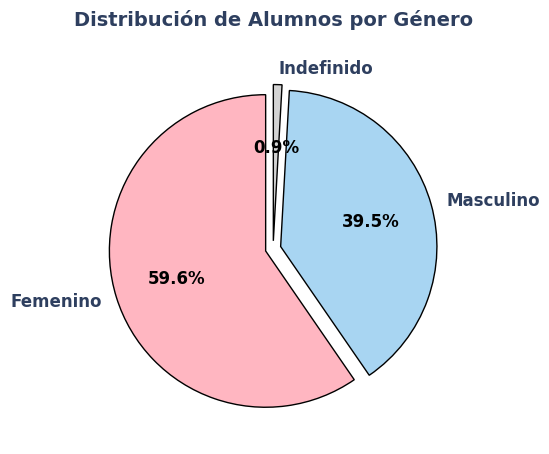

In [231]:
# 1. DISTRIBUCIÓN POR GÉNERO
dist_genero = df_alumnos.groupby('genero')['id'].nunique().reset_index().sort_values('id', ascending=False)
dist_genero.columns = ['Género', 'Estudiantes']
dist_genero['% del total'] = (dist_genero['Estudiantes'] / dist_genero['Estudiantes'].sum() * 100).round(1)


# Crear figura con dos subplots (gráfico + tabla)
fig_genero = plt.figure(figsize=(10, 5), constrained_layout=True)
gs = fig_genero.add_gridspec(1, 2, width_ratios=[1, 1], wspace=0.3)

# --- SUBPLOT 1: Gráfico de Torta ---
ax_pie = fig_genero.add_subplot(gs[0])


# Mapeo de colores específicos por género
color_map = {
    'Masculino': '#A8D5F2',  # Azul pastel
    'Femenino': '#FFB6C1',   # Rosa pastel
    'Indefinido': '#D3D3D3'  # Gris
}

# Asignar colores según el género en el DataFrame
colores = [color_map.get(genero, '#CCCCCC') for genero in dist_genero['Género']]
explode = [0.05] * len(dist_genero)  # Crear lista con 0.05 para cada categoría

wedges, texts, autotexts = ax_pie.pie(
    dist_genero['Estudiantes'],
    labels=dist_genero['Género'],
    autopct='%1.1f%%',
    startangle=90,
    colors=colores,
    explode=explode,
    shadow=False,
    textprops={'fontsize': 11, 'weight': 'bold'},
    wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True}
)

# Estilo de los porcentajes (blancos sobre el gráfico)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)
    autotext.set_weight('bold')

# Estilo de las etiquetas
for text in texts:
    text.set_fontsize(12)
    text.set_weight('bold')
    text.set_color('#2E3F5F')

ax_pie.set_title('Distribución de Alumnos por Género', 
                 fontsize=14, weight='bold', pad=20, color='#2E3F5F')


plt.show()

biblioteca['genero'] = {
    'name': 'distribucion_por_genero',
    'fig': fig_genero,
    'df': dist_genero
}

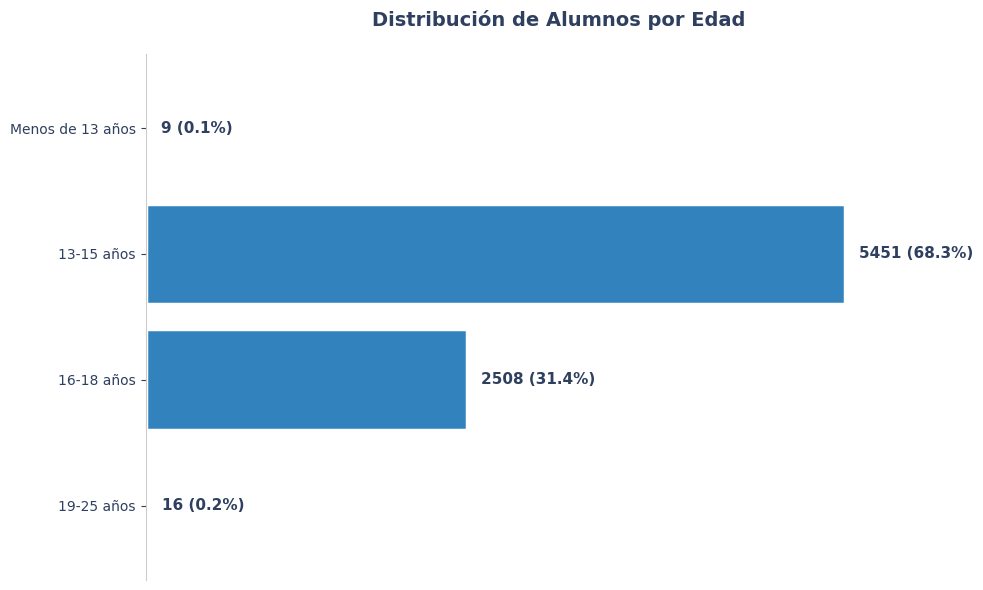

In [232]:
# 2. DISTRIBUCIÓN POR RANGO DE EDAD
def categorizar_edad(edad):
    if pd.isna(edad):
        return 'Sin información'
    elif 13 <= edad <= 15:
        return '13-15 años'
    elif 16 <= edad <= 18:
        return '16-18 años'
    elif 19 <= edad <= 25:
        return '19-25 años'
    elif 26 <= edad <= 30:
        return '26-30 años'
    elif 31 <= edad <= 40:
        return '31-40 años'
    elif 41 <= edad <= 50:
        return '41-50 años'
    elif 51 <= edad <= 60:
        return '51-60 años'
    elif edad >= 61:
        return '61+ años'
    else:
        return 'Menos de 13 años'

df_alumnos['rango_edad'] = df_alumnos['edad'].apply(categorizar_edad)


dist_edad = df_alumnos.groupby('rango_edad')['id'].nunique().reset_index()
dist_edad.columns = ['Rango de Edad', 'Estudiantes']
dist_edad['% del total'] = (dist_edad['Estudiantes'] / dist_edad['Estudiantes'].sum() * 100).round(1)

# Ordenar por rango
orden_edad = ['Menos de 13 años', '13-15 años', '16-18 años', '19-25 años', '26-30 años', '31-40 años', '41-50 años', '51-60 años', '61+ años', 'Sin información']
dist_edad['Rango de Edad'] = pd.Categorical(dist_edad['Rango de Edad'], categories=orden_edad, ordered=True)
dist_edad = dist_edad.sort_values('Rango de Edad')

# 1. Distribución por Edad
fig_edad = crear_grafico_distribucion(
    df_distribucion=dist_edad,
    col_categoria='Rango de Edad',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por Edad',
    label_y=''
)

biblioteca['edad'] = {
    'name': 'distribucion_por_rango_etario',
    'fig': fig_edad,
    'df': dist_edad
}

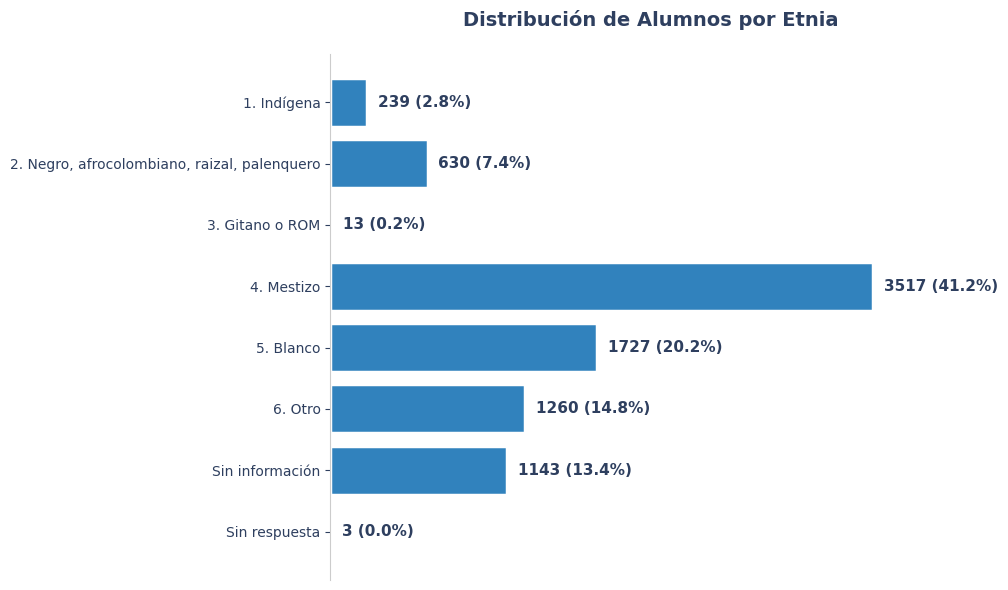

In [233]:
# 4. DISTRIBUCIÓN POR ETNIA/ASCENDENCIA
# Desagregar etnias concatenadas (separadas por |)
def desagregar_etnias(df, columna_etnia='etnia'):
    """
    Desagrega etnias cuando un estudiante tiene múltiples valores separados por |
    """
    # Lista para almacenar los registros desagregados
    registros_desagregados = []
    
    for idx, row in df.iterrows():
        etnia_valor = row[columna_etnia]
        
        # Si el valor es nulo o vacío
        if pd.isna(etnia_valor) or str(etnia_valor).strip() == '':
            registros_desagregados.append({
                'id': row['id'],
                'etnia_individual': 'Sin información'
            })
        else:
            # Separar por | y crear un registro por cada etnia
            etnias = str(etnia_valor).split(';')
            for etnia in etnias:
                etnia_limpia = etnia.strip()
                if etnia_limpia:  # Solo si no está vacío
                    registros_desagregados.append({
                        'id': row['id'],
                        'etnia_individual': etnia_limpia
                    })
    
    return pd.DataFrame(registros_desagregados)

# Desagregar las etnias
df_etnias_desagregadas = desagregar_etnias(df_alumnos)

# Calcular distribución
dist_etnia = df_etnias_desagregadas.groupby('etnia_individual')['id'].nunique().reset_index()
dist_etnia.columns = ['Etnia/Ascendencia', 'Identificadas']
dist_etnia=dist_etnia.sort_values('Etnia/Ascendencia')

# Calcular porcentaje sobre el total de estudiantes únicos
total_estudiantes = df_alumnos['id'].nunique()
dist_etnia['% del total'] = (dist_etnia['Identificadas'] / total_estudiantes * 100).round(1)

# grafico
fig_etnia = crear_grafico_distribucion(
    df_distribucion=dist_etnia,
    col_categoria='Etnia/Ascendencia',
    col_cantidad='Identificadas',
    titulo_grafico='Distribución de Alumnos por Etnia',
    label_y='',
    colormap='#3182bd')

biblioteca['etnia'] = {
    'name': 'distribucion_por_etnia',
    'fig': fig_etnia,
    'df': dist_etnia
}

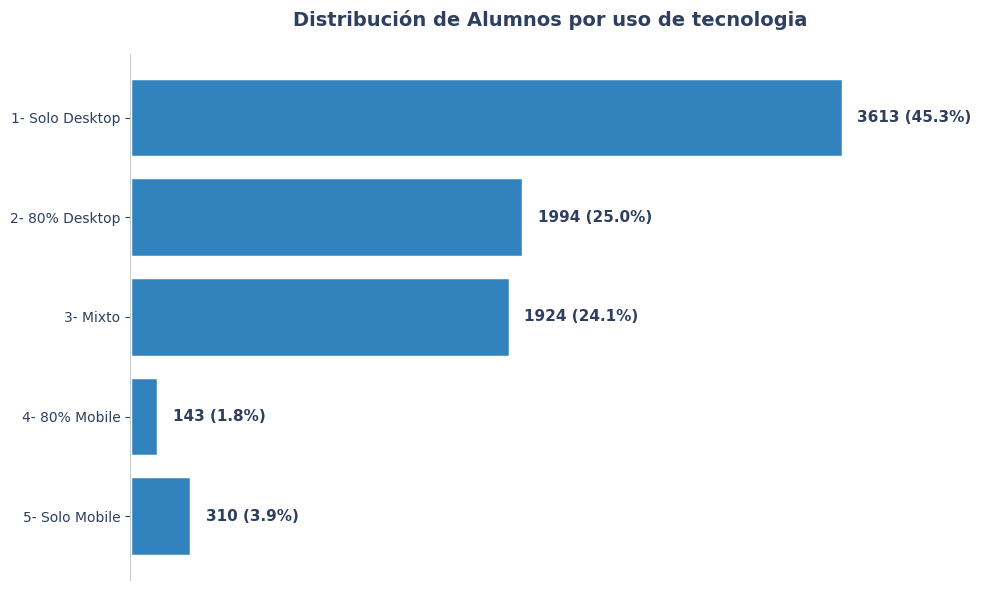

In [234]:
dist_dispositivo=df_alumnos.groupby('dispositivo')['id'].nunique().reset_index()
dist_dispositivo.columns =  ['Dispositivo', 'Estudiantes']
dist_dispositivo['% del total'] = (dist_dispositivo['Estudiantes'] / dist_dispositivo['Estudiantes'].sum()*100).round(1)
dist_dispositivo=dist_dispositivo.sort_values('Dispositivo')

fig_dispositivo = crear_grafico_distribucion(
    df_distribucion=dist_dispositivo,
    col_categoria='Dispositivo',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por uso de tecnologia',
    label_y='',
    colormap='#3182bd'
)

biblioteca['dispositivo'] = {
    'name': 'distribucion_por_dispositivo',
    'fig': fig_dispositivo,
    'df': dist_dispositivo
}

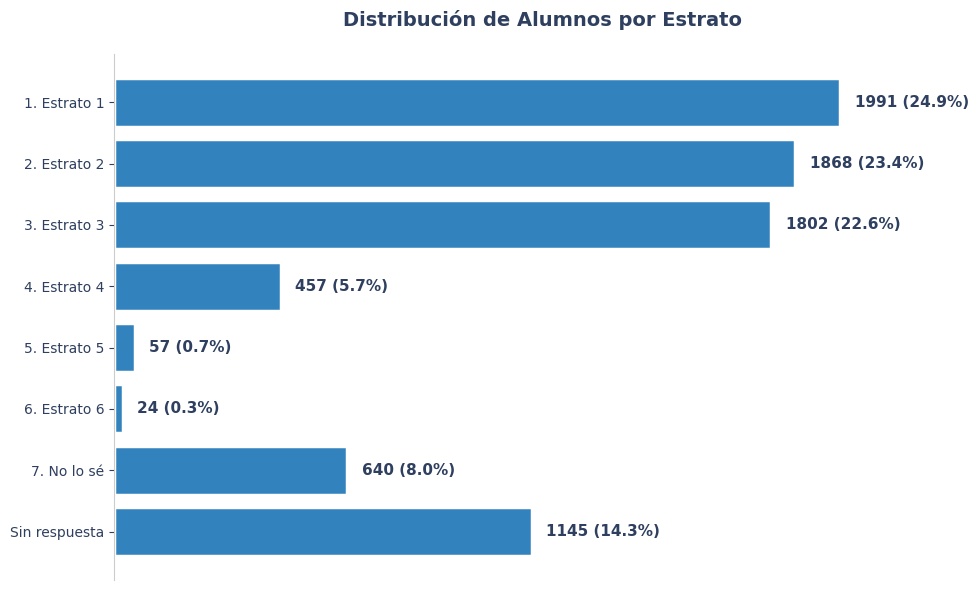

In [235]:
# 3. DISTRIBUCIÓN POR ESTRATO SOCIOECONÓMICO
dist_estrato = df_alumnos.groupby('estrato_socioeconomico')['id'].nunique().reset_index()
dist_estrato.columns = ['Estrato', 'Estudiantes']
dist_estrato['Porcentaje'] = (dist_estrato['Estudiantes'] / dist_estrato['Estudiantes'].sum() * 100).round(1)
dist_estrato = dist_estrato.sort_values('Estrato')

fig_estrato = crear_grafico_distribucion(
    df_distribucion=dist_estrato,
    col_categoria='Estrato',
    col_cantidad='Estudiantes',
    titulo_grafico='Distribución de Alumnos por Estrato',
    label_y='',
    colormap='#3182bd')

biblioteca['estrato'] = {
    'name': 'Distribucion por estrato economico',
    'fig': fig_estrato,
    'df': dist_estrato
}

# Analisis de asistencia

## Funciones

In [236]:
def crear_grafico_cards(datos_cards, titulo_general="Dashboard de Métricas", 
                        filas=1, columnas=None, figsize=None):
    """
    Crea un gráfico con múltiples cards de información.
    
    Parámetros:
    -----------
    datos_cards : list of dict
        Lista de diccionarios con la información de cada card.
        Cada diccionario debe tener:
        - 'titulo': str - Título de la card
        - 'valor': float o str - Valor principal a mostrar
        - 'subtitulo': str (opcional) - Texto debajo del valor
        - 'sufijo': str (opcional) - Sufijo para el valor (ej: '%', 'hrs', etc.)
    
    titulo_general : str
        Título general del gráfico
    
    filas : int
        Número de filas para organizar las cards
    
    columnas : int (opcional)
        Número de columnas. Si no se especifica, se calcula automáticamente
    
    figsize : tuple (opcional)
        Tamaño de la figura (ancho, alto)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        La figura creada
    
    Ejemplo de uso:
    ---------------
    datos = [
        {'titulo': 'Asistencia General', 'valor': 85.5, 'sufijo': '%', 
         'subtitulo': 'Promedio mensual'},
        {'titulo': 'Horas Trabajadas', 'valor': 160, 'sufijo': ' hrs', 
         'subtitulo': 'Este mes'},
        {'titulo': 'Proyectos Activos', 'valor': 12, 
         'subtitulo': 'En desarrollo'}
    ]
    fig = crear_grafico_cards(datos)
    plt.show()
    """
    
    num_cards = len(datos_cards)
    
    # Calcular columnas automáticamente si no se especifica
    if columnas is None:
        columnas = min(3, num_cards)  # Máximo 3 columnas
        filas = (num_cards + columnas - 1) // columnas
    
    # Calcular figsize automáticamente si no se especifica
    if figsize is None:
        ancho = columnas * 5
        alto = filas * 3.5
        figsize = (ancho, alto)
    
    # Crear figura
    fig = plt.figure(figsize=figsize)
    fig.suptitle(titulo_general, fontsize=16, weight='bold', y=0.98)
    
    # Crear grid
    gs = gridspec.GridSpec(filas, columnas, figure=fig, 
                          hspace=0.4, wspace=0.3,
                          left=0.08, right=0.92, top=0.92, bottom=0.08)
    
    # Crear cada card
    for idx, card_data in enumerate(datos_cards):
        fila = idx // columnas
        col = idx % columnas
        
        ax = fig.add_subplot(gs[fila, col])
        ax.axis('off')
        
        # Extraer datos de la card
        titulo = card_data.get('titulo', 'Sin título')
        valor = card_data.get('valor', 0)
        subtitulo = card_data.get('subtitulo', '')
        sufijo = card_data.get('sufijo', '')
        
        # Crear tarjeta con bordes redondeados
        card = FancyBboxPatch(
            (0.05, 0.1), 0.9, 0.8,
            boxstyle="round,pad=0.05",
            facecolor='#E3F2FD',      # Azul muy claro de fondo
            edgecolor='#1565C0',       # Azul oscuro para borde
            linewidth=2.5,
            transform=ax.transAxes,
            zorder=1
        )
        ax.add_patch(card)
        
        # Título de la tarjeta
        ax.text(
            0.5, 0.75,
            titulo,
            ha='center',
            va='center',
            fontsize=12,
            weight='bold',
            color='#0D47A1',          # Azul oscuro
            transform=ax.transAxes,
            wrap=True
        )
        
        # Valor principal (NEGRO)
        valor_texto = f'{valor}{sufijo}' if isinstance(valor, (int, float)) else str(valor)
        
        # Ajustar tamaño de fuente según longitud del texto
        if len(valor_texto) > 8:
            fontsize_valor = 32
        elif len(valor_texto) > 6:
            fontsize_valor = 38
        else:
            fontsize_valor = 44
        
        ax.text(
            0.5, 0.45,
            valor_texto,
            ha='center',
            va='center',
            fontsize=fontsize_valor,
            weight='bold',
            color='black',            # COLOR NEGRO para el porcentaje/valor
            transform=ax.transAxes
        )
        
        # Subtítulo (si existe)
        if subtitulo:
            ax.text(
                0.5, 0.2,
                subtitulo,
                ha='center',
                va='center',
                fontsize=9,
                color='#424242',      # Gris oscuro
                transform=ax.transAxes,
                style='italic'
            )
        
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
    
    return fig

In [237]:
def asistencia_por(df: dataframes, agrupacion: str):

    # Calcular % de asistencias por proyecto
    asistencias_por = (
        df.groupby(agrupacion)
        .apply(lambda grupo: pd.Series({
            'Total_registros': grupo['attendance_id'].nunique(),
            'Asistencias': grupo[grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique(),
            'Faltas': grupo[~grupo['attendance_status'].isin(['A', 'T', 'J'])]['attendance_id'].nunique()
        }), include_groups=False)
        .reset_index()
    )

    asistencias_por['% Asistencia'] = round(
        (asistencias_por['Asistencias'] / asistencias_por['Total_registros']) * 100, 1
    )

    asistencias_por['% Falta'] = round(
        (asistencias_por['Faltas'] / asistencias_por['Total_registros']) * 100, 1
    )

    asistencias_por.drop(columns=['Faltas', 'Asistencias', 'Total_registros'], inplace=True)

    # Agregar a la biblioteca
    biblioteca['asistencias_proyecto'] = {
        'name': 'Porcentaje de asistencias por proyecto',
        'df': asistencias_por
    }

    return asistencias_por

In [238]:
def grafico_columnas_asistencia(df: dataframes, guardar: str, titulo_grafico: str,
                                xlabel: str = 'Mes', ylabel: str = '% Asistencia'):
    """
    Crea un gráfico de columnas con la asistencia mensual en formato profesional.
   
    Parámetros:
    -----------
    df : dataframes
        DataFrame con los datos de asistencia
    guardar : str
        Clave para guardar en la biblioteca
    titulo_grafico : str
        Título principal del gráfico
    xlabel : str
        Etiqueta del eje X (por defecto 'Mes')
    ylabel : str
        Etiqueta del eje Y (por defecto '% Asistencia')
   
    Returns:
    --------
    fig : matplotlib.figure.Figure
    """
   
    # Obtener datos de asistencia por mes
    asistencia_mes = asistencia_por(df, 'mes').sort_values('mes')
   
    # Crear figura
    fig, ax = plt.subplots(figsize=(12, 6))
    fig.patch.set_facecolor('white')
   
    # Color sólido profesional
    color_barras = '#3182bd'
   
    # Crear gráfico de barras
    bars = ax.bar(
        asistencia_mes['mes'],
        asistencia_mes['% Asistencia'],
        color=color_barras,
        edgecolor='#1565C0',
        linewidth=1.5,
        alpha=0.9,
        width=0.7
    )
   
    # Agregar etiquetas sobre las barras con valores
    for bar, porcentaje in zip(bars, asistencia_mes['% Asistencia']):
        altura = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            altura + 1.2,
            f'{porcentaje:.1f}%',
            ha='center',
            va='bottom',
            fontsize=11,
            weight='bold',
            color='#0D47A1'
        )
   
    # Título principal
    ax.set_title(
        titulo_grafico,
        fontsize=16,
        weight='bold',
        pad=20,
        color='#1565C0'
    )
   
    # Etiquetas de ejes
    ax.set_xlabel(xlabel, fontsize=12, weight='bold', color='#424242', labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, weight='bold', color='#424242', labelpad=10)
   
    # Grilla sutil para facilitar la lectura
    ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#BBDEFB')
    ax.set_axisbelow(True)
   
    # Estilo de los bordes (spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#90CAF9')
    ax.spines['bottom'].set_color('#90CAF9')
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
   
    # Estilo de los ticks
    ax.tick_params(
        axis='x',
        colors='#424242',
        labelsize=10,
        rotation=45,
        length=5,
        width=1.5
    )
    ax.tick_params(
        axis='y',
        colors='#424242',
        labelsize=10,
        length=5,
        width=1.5
    )
    ax.set_yticks([])
   
    # Ajustar límites del eje Y para mejor visualización
    ax.set_ylim(0, 108)
   
    # Ajustar layout para que no se corten las etiquetas
    plt.tight_layout()
   
    # Guardar en biblioteca
    biblioteca[f'asistencia_{guardar}'] = {
        'name': 'grafico_columnas_asistencia',
        'fig': fig,
        'df': asistencia_mes
    }
   
    return fig


## Analisis

In [239]:
promedio_alumnos_asistentes_por_salon=int(
    df_asistencias[df_asistencias['attendance_status']=='A']
    .groupby('room_id')['student_id']
    .nunique()
    .mean()
    )

In [240]:
df_asistencias['start_date'] = pd.to_datetime(df_asistencias['start_date'])
df_asistencias['mes'] = df_asistencias['start_date'].dt.to_period('M').astype(str)
df_asistencia_profe = df_asistencias[df_asistencias['content_definition'] == 'Profesor CTC'].copy()
df_asistencia_alumno = df_asistencias[df_asistencias['content_definition'] == 'Alumno'].copy()

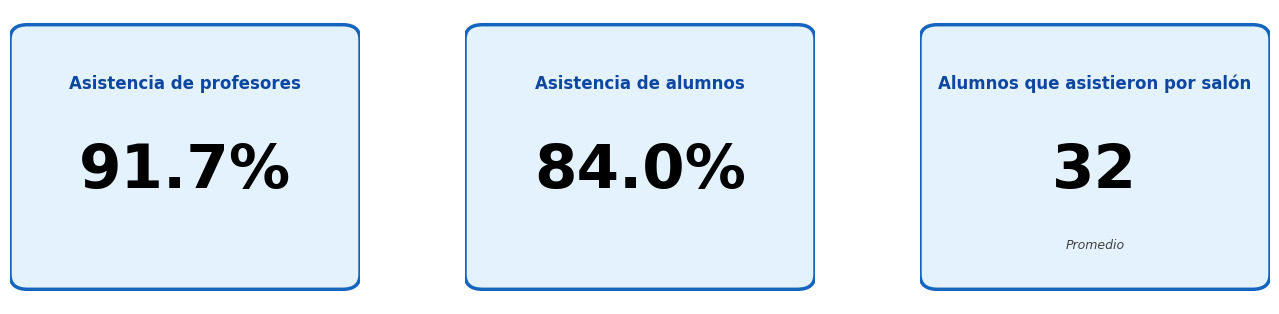

In [241]:
datos_asistencia = [
    {
        'titulo': 'Asistencia de profesores',
        'valor': asistencia_por(df_asistencia_profe, 'name')['% Asistencia'][0],
        'sufijo': '%'
    },
    {
        'titulo': 'Asistencia de alumnos',
        'valor': asistencia_por(df_asistencia_alumno, 'name')['% Asistencia'][0],
        'sufijo': '%'
    },
    {
        'titulo': 'Alumnos que asistieron por salón',
        'valor': promedio_alumnos_asistentes_por_salon,
        'subtitulo': 'Promedio'
    }
]

fig_tarjetas_asistencias= crear_grafico_cards(datos_asistencia, titulo_general="")
plt.show()

2025-10-28 16:15:03,901 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-28 16:15:03,903 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


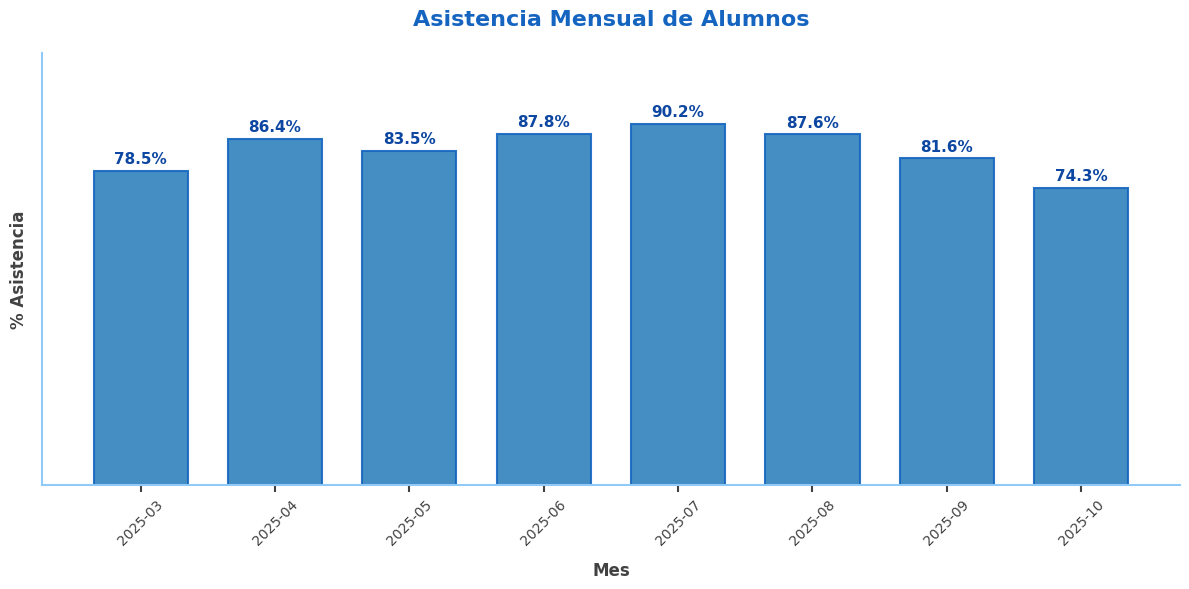

In [242]:
fig_asistencia_alumno= grafico_columnas_asistencia(
    df=df_asistencia_alumno,
    guardar='alumno',
    titulo_grafico='Asistencia Mensual de Alumnos'
)

2025-10-28 16:15:04,207 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-10-28 16:15:04,211 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


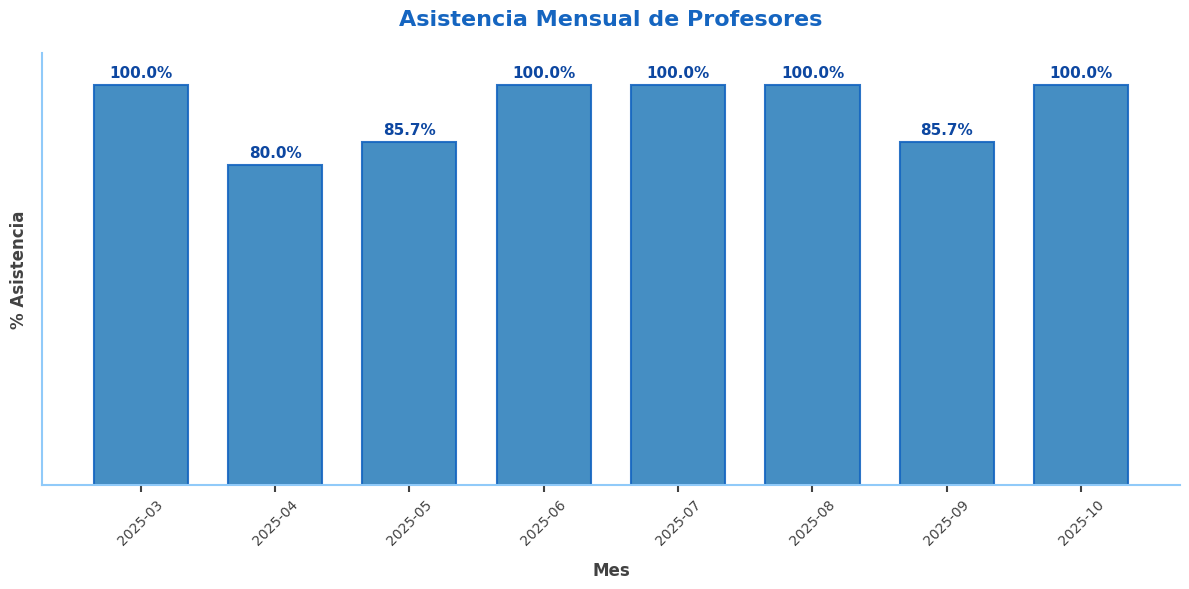

In [243]:
fig_asistencia_profe= grafico_columnas_asistencia(
    df=df_asistencia_profe,
    guardar='profesor',
    titulo_grafico='Asistencia Mensual de Profesores'
)

# Cancelaciones

In [244]:
df_cancelaciones.columns

Index(['projectsid', 'proyecto', 'canal', 'tipo de programa', 'organización',
       'institucion', 'seccion', 'career', 'room', 'room name', 'link room',
       'sesionid', 'sesion', 'grado', 'reasonid', 'motivo', 'fecha', 'hora',
       'hora agrupada', 'ordensemana', 'semana', 'dia', 'state', 'riesgo',
       'profesor'],
      dtype='object')

In [245]:
## --- TARJETAS GENERALES DE CANCELACIONES --- ## 
sesiones_canceladas=df_cancelaciones[df_cancelaciones['state']=='false']['sesionid'].nunique()
sesiones_programadas=df_cancelaciones['sesionid'].nunique()
porcentaje_cancelacion=round((sesiones_canceladas / sesiones_programadas)*100,2)
porcentaje_dictado=round(100-porcentaje_cancelacion,2)

## -- RESUMEN POR PROYECTO DE CANCELACIONES -- ##
resumen_cancelaciones_por_proyecto=df_cancelaciones.groupby('projectsid').agg(
    sesiones_programadas=('sesionid', 'nunique'),
    sesiones_canceladas=('sesionid', lambda x: df_cancelaciones.loc[x.index][df_cancelaciones.loc[x.index, 'state'] == 'false']['sesionid'].nunique())
)

resumen_cancelaciones_por_proyecto['% Cancelación']=round(
    resumen_cancelaciones_por_proyecto['sesiones_canceladas'] 
    / resumen_cancelaciones_por_proyecto['sesiones_programadas'] * 100,2)

resumen_cancelaciones_por_proyecto['% Dictado']=round(100-resumen_cancelaciones_por_proyecto['% Cancelación'],2)

resumen_cancelaciones_por_proyecto.rename(columns={'sesiones_programadas':'Sesiones programadas', 'sesiones_canceladas':'Sesiones canceladas'}, inplace=True)
## -- MOTIVOS DE CANCELACIONES -- ## 

resumen_motivos_cancalaciones=(
    df_cancelaciones[df_cancelaciones['state']=='false']
    .groupby('motivo')
    .agg(
        sesiones_canceladas=('sesionid', 'nunique')
    )
    ).sort_values('sesiones_canceladas', ascending=False
    ).reset_index()

resumen_motivos_cancalaciones['% Cancelación']=round(
    resumen_motivos_cancalaciones['sesiones_canceladas'] 
    / sesiones_canceladas * 100,1)
    
resumen_motivos_cancalaciones.rename(columns={'motivo':'Motivo', 'sesiones_canceladas': 'Sesiones canceladas'}, inplace=True)

## -- CANCELACIONES POR IE -- ## 

resumen_cancelaciones_IE=(
    df_cancelaciones[df_cancelaciones['state']=='false']
    .groupby('institucion')
    .agg(
        sesiones_canceladas=('sesionid', 'nunique')
    )
    ).sort_values('sesiones_canceladas', ascending=False
    ).reset_index()
    
resumen_cancelaciones_IE['% Cancelación']=round(
    resumen_cancelaciones_IE['sesiones_canceladas'] 
    / sesiones_canceladas * 100,1)
    
resumen_cancelaciones_IE.rename(columns={'institucion':'Institución', 'sesiones_canceladas': 'Sesiones canceladas'}, inplace=True)

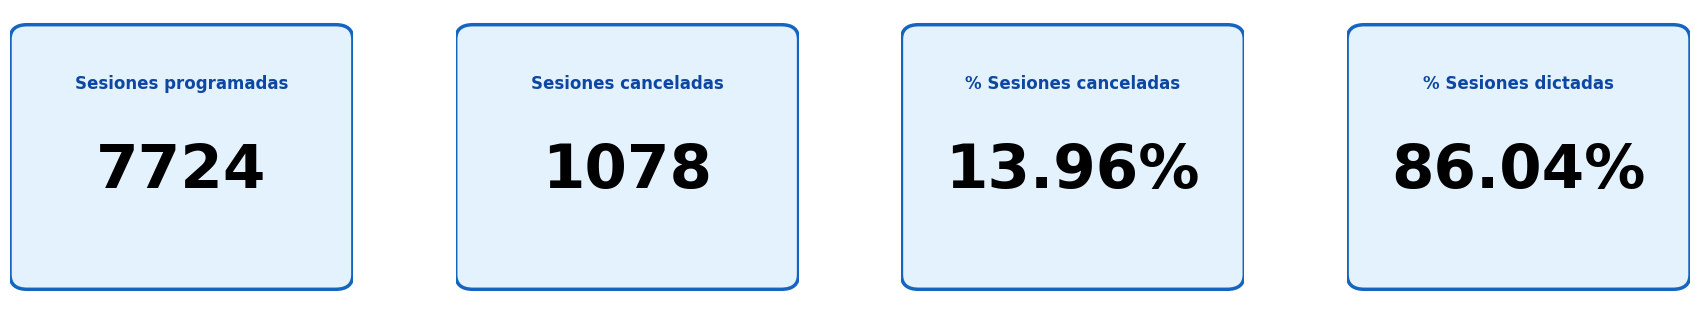

In [246]:
datos_cancelaciones = [
    {
        'titulo': 'Sesiones programadas',
        'valor': sesiones_programadas,
    },
    {
        'titulo': 'Sesiones canceladas',
        'valor': sesiones_canceladas
    },
    {
        'titulo': '% Sesiones canceladas',
        'valor': porcentaje_cancelacion,
        'sufijo': '%'
    },
    {
        'titulo': '% Sesiones dictadas',
        'valor': porcentaje_dictado,
        'sufijo': '%'
    }
]

fig_tarjetas_cancelaciones= crear_grafico_cards(datos_cancelaciones, titulo_general="", filas=1, columnas=4)
plt.show()

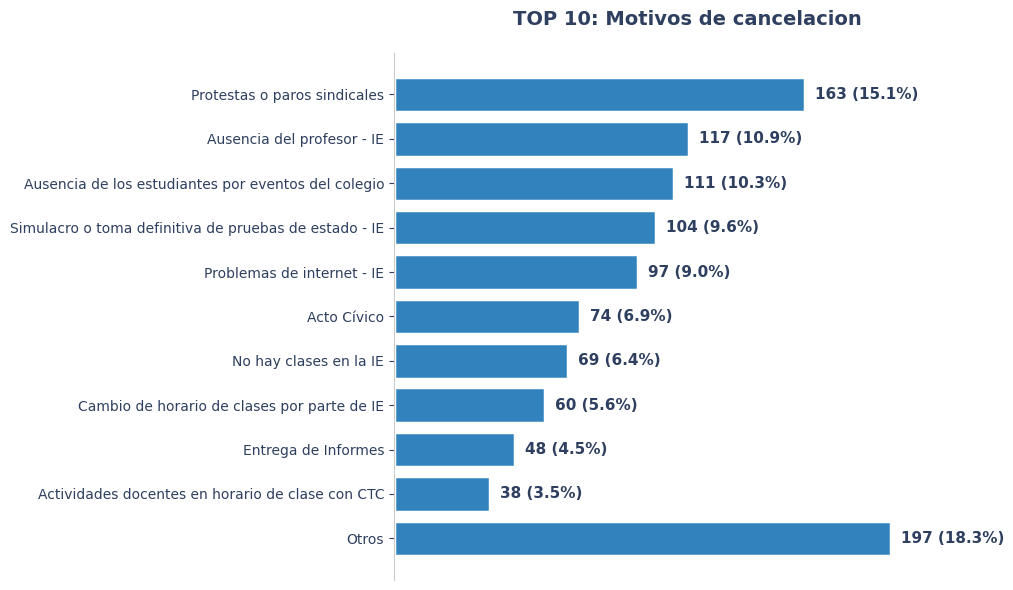

In [247]:
top_10_motivos_cancelacion=crear_top_n_con_otros(
    df=resumen_motivos_cancalaciones,
    columna_categoria='Motivo',
    columna_valor='Sesiones canceladas',
    n=10
)

fig_top_10_cancelaciones = crear_grafico_distribucion(
    df_distribucion=top_10_motivos_cancelacion,
    col_categoria='Motivo',
    col_cantidad='Sesiones canceladas',
    titulo_grafico='TOP 10: Motivos de cancelacion',
    label_y='',
    colormap= '#3182bd'
)

# Cuestionarios

In [248]:
# Función para clusterizar notas en rangos de 5 en 5
def clusterizar_notas(nota):
    """
    Clusteriza las notas en rangos de 5 en 5 puntos.
    
    Parámetros:
    -----------
    nota : float
        La nota a clusterizar
    
    Returns:
    --------
    str : Rango de la nota (ej: "0-5", "5-10", etc.)
    """
    if pd.isna(nota):
        return 'Sin nota'
    
    # Calcular el límite inferior del rango
    limite_inferior = int(nota // 5) * 5
    limite_superior = limite_inferior + 5
    
    return f"{limite_inferior}-{limite_superior}"

# Aplicar la función al DataFrame
df_calificaciones['cluster_nota'] = df_calificaciones['nota_final_ponderada'].apply(clusterizar_notas)

In [249]:
alumnos_aprobados=df_calificaciones[df_calificaciones['nota_final_ponderada']>=60]['student_id'].nunique()
alumnos_desaprobados=df_calificaciones[df_calificaciones['nota_final_ponderada']<60]['student_id'].nunique()
total_evaluados=df_calificaciones[~df_calificaciones['nota_final_ponderada'].isnull()]['student_id'].nunique()
porcentaje_aprobacion=round((alumnos_aprobados / total_evaluados)*100,1)
porcentaje_desaprobacion=round((alumnos_desaprobados / total_evaluados)*100,1)
nota_promedio=df_calificaciones['nota_final_ponderada'].mean().astype(int)

alumnos_activos=df_alumnos['id'].nunique()
porcentaje_evaluados=round((total_evaluados / alumnos_activos)*100,1)

datos_cuestionarios = [
    {
        'titulo': 'Evaluados',
        'valor': total_evaluados
    },
    {
        'titulo': 'Aprobados',
        'valor': alumnos_aprobados,
        'sufijo': '',
    },
    {
        'titulo': 'Nota promedio',
        'valor': nota_promedio,
        'sufijo': '',
    },
    {
        'titulo': '% Evaluados',
        'valor': porcentaje_evaluados,
        'sufijo': '%'
    },
    {
        'titulo': '% Aprobación',
        'valor': porcentaje_aprobacion,
        'sufijo': '%'
    },
    {
        'titulo': '% Desaprobación',
        'valor': porcentaje_desaprobacion,
        'sufijo': '%'
    }
]

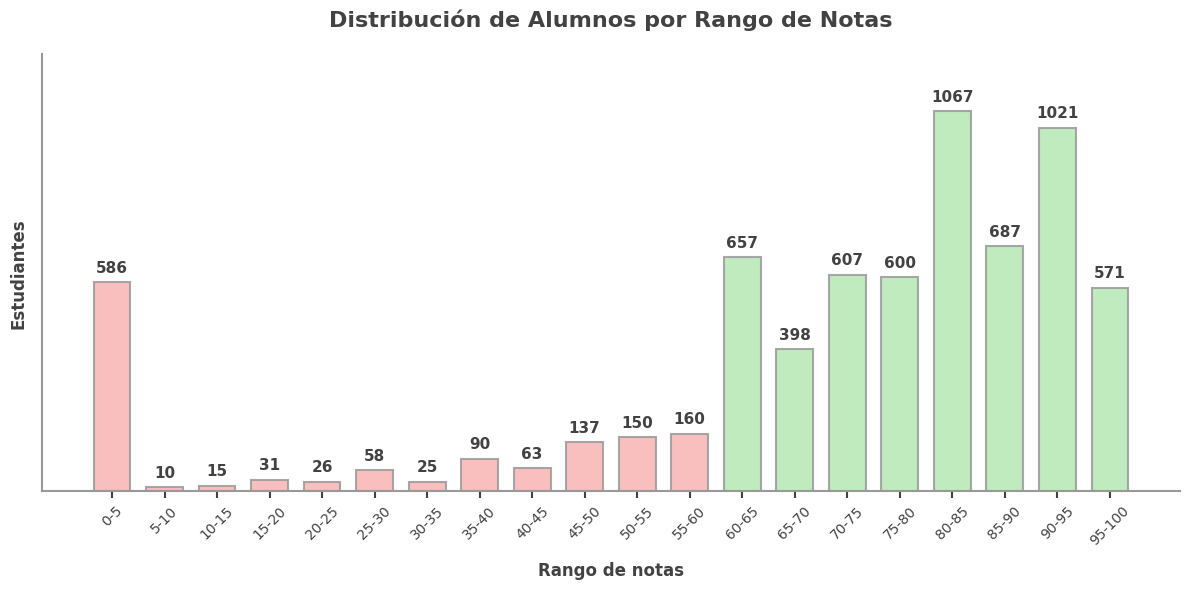

In [250]:
dist_notas = df_calificaciones.groupby('cluster_nota')['student_id'].nunique().reset_index()
dist_notas.columns = ['Cluster', 'Estudiantes']

# Ordenar los clusters correctamente
orden_clusters = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', 
                  '40-45', '45-50', '50-55', '55-60', '60-65', '65-70', '70-75', '75-80', 
                  '80-85', '85-90', '90-95', '95-100']

# Filtrar solo los que existen y ordenar
dist_notas['Cluster'] = pd.Categorical(dist_notas['Cluster'], categories=orden_clusters, ordered=True)
dist_notas = dist_notas.sort_values('Cluster').dropna()

# Crear lista de colores según el cluster
colores = []
for cluster in dist_notas['Cluster']:
    if cluster in ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-35', '35-40', 
                   '40-45', '45-50', '50-55', '55-60']:
        colores.append('#F8B4B4')  # Rojo pastel suave
    else:  # 65-70 en adelante
        colores.append('#B4E8B4')  # Verde pastel suave

# Crear figura
fig_distri_notas, ax = plt.subplots(figsize=(12, 6))
fig_distri_notas.patch.set_facecolor('white')

# Crear gráfico de barras con colores personalizados
bars = ax.bar(
    dist_notas['Cluster'],
    dist_notas['Estudiantes'],
    color=colores,
    edgecolor='#999999',
    linewidth=1.5,
    alpha=0.85,
    width=0.7
)

# Agregar etiquetas sobre las barras con NÚMERO de estudiantes
for bar, estudiantes in zip(bars, dist_notas['Estudiantes']):
    altura = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        altura + (dist_notas['Estudiantes'].max() * 0.02),
        f'{int(estudiantes)}',
        ha='center',
        va='bottom',
        fontsize=11,
        weight='bold',
        color='#424242'
    )

ax.set_title(
    'Distribución de Alumnos por Rango de Notas',
    fontsize=16,
    weight='bold',
    pad=20,
    color='#424242'
)
ax.set_xlabel('Rango de notas', fontsize=12, weight='bold', color='#424242', labelpad=10)
ax.set_ylabel('Estudiantes', fontsize=12, weight='bold', color='#424242', labelpad=10)
ax.grid(axis='y', alpha=0.25, linestyle='--', linewidth=0.8, color='#CCCCCC')
ax.set_axisbelow(True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#999999')
ax.spines['bottom'].set_color('#999999')
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

ax.tick_params(axis='x', colors='#424242', labelsize=10, rotation=45, length=5, width=1.5)
ax.tick_params(axis='y', colors='#424242', labelsize=10, length=5, width=1.5)

# Ajustar límites dinámicamente
ax.set_ylim(0, dist_notas['Estudiantes'].max() * 1.15)
ax.set_yticks([])


plt.tight_layout()
plt.show()

In [251]:
cuestionarios_institucion=df_calificaciones.groupby('institution').agg(
    evaluados=('student_id', 'nunique'),
    aprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] >= 60]['student_id'].nunique()),
    desaprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] < 60]['student_id'].nunique()),
    nota_promedio=('nota_final_ponderada', 'mean')
).reset_index()

cuestionarios_institucion.columns=['Institución', 'Evaluados', 'Aprobados', 'Desaprobados', 'Nota promedio']

cuestionarios_institucion['% Aprobación']=round( cuestionarios_institucion['Aprobados']/ cuestionarios_institucion['Evaluados'] * 100,1)
cuestionarios_institucion['% Desaprobados']=round( cuestionarios_institucion['Desaprobados']/ cuestionarios_institucion['Evaluados'] * 100,1)
cuestionarios_institucion['Nota promedio']= cuestionarios_institucion['Nota promedio'].astype(int)

cuestionarios_institucion.sort_values('% Aprobación', ascending=False, inplace=True)

In [252]:
cuestionarios_grado=df_calificaciones.groupby('grade').agg(
    evaluados=('student_id', 'nunique'),
    aprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] >= 60]['student_id'].nunique()),
    desaprobados=('student_id', lambda x: df_calificaciones.loc[x.index][df_calificaciones.loc[x.index, 'nota_final_ponderada'] < 60]['student_id'].nunique()),
    nota_promedio=('nota_final_ponderada', 'mean')
).reset_index()

cuestionarios_grado.columns=['Institución', 'Evaluados', 'Aprobados', 'Desaprobados', 'Nota promedio']

cuestionarios_grado['% Aprobación']=round( cuestionarios_grado['Aprobados']/ cuestionarios_grado['Evaluados'] * 100,1)
cuestionarios_grado['% Desaprobados']=round( cuestionarios_grado['Desaprobados']/ cuestionarios_grado['Evaluados'] * 100,1)
cuestionarios_grado['Nota promedio']= cuestionarios_grado['Nota promedio'].astype(int)

cuestionarios_grado.sort_values('% Aprobación', ascending=False, inplace=True)

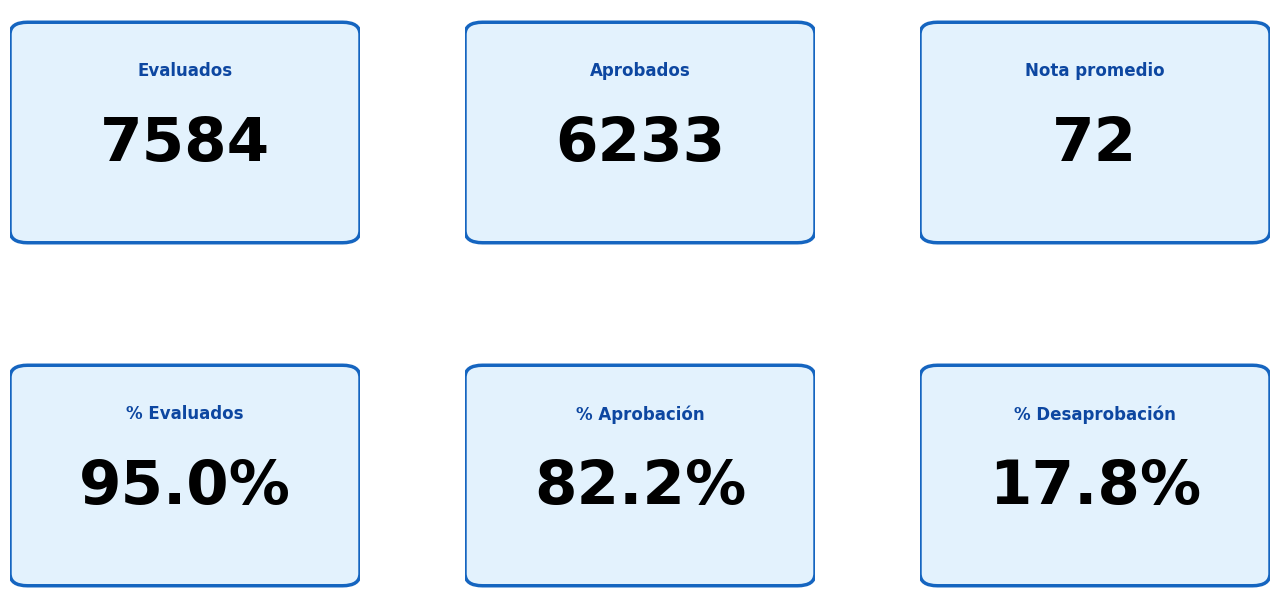

In [253]:
fig_tarjeta_cuestionarios=crear_grafico_cards(datos_cuestionarios, titulo_general="", filas=2, columnas=3)

In [254]:
cuestionarios_institucion

,Institución,Evaluados,Aprobados,Desaprobados,Nota promedio,% Aprobación,% Desaprobados
11,I.E.D. Fundación Pies Descalzos,272,265,7,81,97.4,2.6
7,I.E.D. El Campito,218,211,6,86,96.8,2.8
16,I.E.D. Marie Poussepin,367,355,11,85,96.7,3.0
10,I.E.D. Experiencias Pedagógicas,181,173,4,89,95.6,2.2
6,I.E.D. Cruzada Social,282,268,14,81,95.0,5.0
9,I.E.D. Evardo Turizo,347,328,12,83,94.5,3.5
17,I.E.D. María Cano,367,341,26,76,92.9,7.1
15,I.E.D. Manuel Zapata,232,211,16,74,90.9,6.9
12,I.E.D. Hogar Mariano,364,323,24,77,88.7,6.6
2,I.E.D. Alexander Von Humboldt,163,143,20,74,87.7,12.3


In [255]:
cuestionarios_grado

,Institución,Evaluados,Aprobados,Desaprobados,Nota promedio,% Aprobación,% Desaprobados
0,10,2488,2041,309,75,82.0,12.4
1,11,2571,2007,407,74,78.1,15.8
2,9,2878,2185,635,67,75.9,22.1


# Satisfaccion

In [256]:
def crear_gauge(valor, valor_max, titulo, valor_min=0, ax=None, figsize=(6, 4)):
    """
    Crea un gráfico tipo reloj (gauge) para visualizar un indicador.
    
    Parámetros:
    -----------
    valor : float
        Valor actual del indicador
    valor_max : int
        Valor máximo posible
    titulo : str
        Título del gauge
    valor_min : int
        Valor mínimo posible (default: 0)
    ax : matplotlib.axes.Axes, optional
        Ejes donde dibujar. Si es None, crea una nueva figura
    figsize : tuple
        Tamaño de la figura (solo se usa si ax es None)
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figura de matplotlib
    ax : matplotlib.axes.Axes
        Ejes de matplotlib
    """
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Crear nueva figura si no se proporciona ax
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.figure
        # IMPORTANTE: Limpiar el eje si ya existe
        ax.clear()
    
    # Calcular el porcentaje
    porcentaje = ((valor - valor_min) / (valor_max - valor_min)) * 100
    
    # Configurar colores según el valor
    if porcentaje >= 80:
        color_gauge = '#4CAF50'  # Verde
    elif porcentaje >= 60:
        color_gauge = '#FFC107'  # Amarillo
    else:
        color_gauge = '#F44336'  # Rojo
    
    # Crear el gauge - semicírculo
    # Ángulos en grados: 180° (izquierda) a 0° (derecha)
    theta = np.linspace(180, 0, 100)
    theta_rad = np.radians(theta)
    
    # Radio del arco
    radius = 1
    
    # Calcular coordenadas x, y para el arco de fondo
    x_bg = radius * np.cos(theta_rad)
    y_bg = radius * np.sin(theta_rad)
    
    # Calcular coordenadas para el valor actual
    theta_valor = np.linspace(180, 180 - (porcentaje/100) * 180, 100)
    theta_valor_rad = np.radians(theta_valor)
    x_valor = radius * np.cos(theta_valor_rad)
    y_valor = radius * np.sin(theta_valor_rad)
    
    # Dibujar el fondo (gris)
    ax.plot(x_bg, y_bg, color='#E0E0E0', linewidth=30, solid_capstyle='round')
    
    # Dibujar el valor actual
    ax.plot(x_valor, y_valor, color=color_gauge, linewidth=30, solid_capstyle='round')
    
    # Configurar el aspecto del gráfico
    ax.set_xlim(-1.3, 1.3)
    ax.set_ylim(-0.3, 1.3)
    ax.set_aspect('equal')
    ax.axis('off')
    
    # Añadir el valor actual en el centro
    ax.text(
        0, 0.2, 
        f'{valor:.2f}', 
        ha='center', 
        va='center',
        fontsize=40,
        weight='bold',
        color=color_gauge
    )
    
    # Añadir etiqueta "Valor actual"
    ax.text(
        0, 0, 
        'Valor actual', 
        ha='center', 
        va='center',
        fontsize=10,
        color='#757575'
    )
    
    # Añadir el mínimo (izquierda)
    ax.text(
        -1.15, 0.05, 
        valor_min, 
        ha='center', 
        va='center',
        fontsize=11,
        color='#757575'
    )
    
    # Añadir el máximo (derecha)
    ax.text(
        1.15, 0.05, 
        valor_max, 
        ha='center', 
        va='center',
        fontsize=11,
        color='#757575'
    )
    
    # Título arriba
    ax.text(
        0, 1.25, 
        titulo, 
        ha='center', 
        va='center',
        fontsize=16,
        weight='bold',
        color='#2E3F5F'
    )
    
    plt.tight_layout()
    return fig, ax

In [257]:
def crear_gauge_barras(df, columna_dimension, columna_valor, columna_max,
                       titulo='Satisfacción por Dimensión',
                       figsize_base=(10, 5),
                       umbrales=(80, 60),
                       guardar_en_biblioteca=False,
                       nombre_biblioteca='gauge_barras'):
    """
    Crea un gráfico de barras tipo gauge para visualizar métricas con valores máximos.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame con los datos a visualizar
    columna_dimension : str
        Nombre de la columna que contiene las dimensiones/categorías
    columna_valor : str
        Nombre de la columna con los valores actuales
    columna_max : str
        Nombre de la columna con los valores máximos/objetivo
    titulo : str, optional
        Título principal del gráfico (default: 'Satisfacción por Dimensión')
    figsize_base : tuple, optional
        Tamaño base de la figura (ancho, alto_por_dimension) (default: (10, 1.8))
    umbrales : tuple, optional
        Umbrales de porcentaje para colores (excelente, bueno) (default: (80, 60))
    guardar_en_biblioteca : bool, optional
        Si True, guarda en la variable global 'biblioteca' (default: False)
    nombre_biblioteca : str, optional
        Nombre de la clave en la biblioteca (default: 'gauge_barras')
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figura de matplotlib creada
    
    Example:
    --------
    >>> df = pd.DataFrame({
    ...     'Dimensión': ['Calidad', 'Servicio', 'Precio'],
    ...     'Puntaje promedio': [4.2, 3.8, 4.5],
    ...     'Puntaje maximo': [5, 5, 5]
    ... })
    >>> fig = crear_gauge_barras(df, 'Dimensión', 'Puntaje promedio', 'Puntaje maximo')
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    
    # Configuración de colores
    color_excelente = '#A8D5E2'  # Azul pastel claro
    color_bueno = '#7FB3D5'      # Azul pastel medio
    color_regular = '#5499C7'    # Azul pastel oscuro
    color_fondo = '#EBF5FB'      # Azul muy claro para fondo
    color_objetivo = '#1B4F72'   # Azul oscuro para línea objetivo
    
    # Crear figura con subplots
    n_dimensiones = len(df)
    fig, axes = plt.subplots(n_dimensiones, 1, 
                             figsize=(figsize_base[0], n_dimensiones * figsize_base[1]))
    
    # Si solo hay una dimensión, convertir axes en lista
    if n_dimensiones == 1:
        axes = [axes]
    
    # Crear cada gauge de barra
    for idx, (ax, (_, row)) in enumerate(zip(axes, df.iterrows())):
        dimension = row[columna_dimension]
        valor = row[columna_valor]
        valor_max = row[columna_max]
        
        # Calcular porcentaje
        porcentaje = (valor / valor_max) * 100
        
        # Determinar color según umbrales
        if porcentaje >= umbrales[0]:
            color_barra = color_excelente
        elif porcentaje >= umbrales[1]:
            color_barra = color_bueno
        else:
            color_barra = color_regular
        
        # Altura de la barra
        altura_barra = 0.5
        
        # Barra de fondo con esquinas redondeadas
        fondo = mpatches.FancyBboxPatch(
            (0, -altura_barra/2), valor_max, altura_barra,
            boxstyle=mpatches.BoxStyle("Round", pad=0.05),
            facecolor=color_fondo,
            edgecolor='#AED6F1',
            linewidth=1.5,
            alpha=0.8
        )
        ax.add_patch(fondo)
        
        # Barra de valor actual con esquinas redondeadas
        barra_valor = mpatches.FancyBboxPatch(
            (0, -altura_barra/2), valor, altura_barra,
            boxstyle=mpatches.BoxStyle("Round", pad=0.05),
            facecolor=color_barra,
            edgecolor='#5DADE2',
            linewidth=2
        )
        ax.add_patch(barra_valor)
        
        # Configurar ejes
        ax.set_xlim(-0.2, valor_max * 1.15)
        ax.set_ylim(-0.6, 0.6)
        ax.axis('off')
        
        # Título de la dimensión (izquierda, arriba)
        ax.text(-0.15, 0.45, dimension, 
                fontsize=13, weight='bold', color='#1B4F72', va='bottom', ha='left')
        
        # Valor actual (dentro de la barra si es posible, o al lado)
        if valor > 1.5:
            pos_x_valor = valor / 2
            color_texto_valor = 'black'
        else:
            pos_x_valor = valor + 0.15
            color_texto_valor = color_barra
        
        ax.text(pos_x_valor, 0, f'{valor:.2f}', 
                fontsize=20, weight='bold', color=color_texto_valor, 
                ha='center', va='center')
        
        # Etiqueta "Meta" en la línea
        ax.text(valor_max, 0.38, f'Meta: {valor_max:.0f}', 
                fontsize=9, color=color_objetivo, ha='center', va='bottom',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                         edgecolor=color_objetivo, alpha=0.8))
        
        # Línea separadora sutil entre dimensiones (excepto la última)
        if idx < n_dimensiones - 1:
            ax.axhline(y=-0.55, color='#D6EAF8', linewidth=1, alpha=0.5)
    
    # Título general
    fig.suptitle(titulo, fontsize=16, weight='bold', color='black', y=0.98)
    
    # Ajustar espaciado
    plt.tight_layout()
    
    # Guardar en biblioteca si se solicita
    if guardar_en_biblioteca and 'biblioteca' in globals():
        biblioteca[nombre_biblioteca] = {
            'name': titulo,
            'fig': fig,
            'data': df
        }
    
    return fig


## Estudiantes

In [258]:
satisfaccion_general=df_satisfaccion[df_satisfaccion['variable'].isin(['programa', 'contenido', 'docente ctc', 'aula virtual'])]['answer_numeric'].mean().round(2)
nps=df_satisfaccion[df_satisfaccion['variable']=='nps']['answer_numeric'].mean().round(2)

In [259]:
distri_csat=df_satisfaccion[df_satisfaccion['variable'].isin(['programa', 'contenido', 'docente ctc', 'aula virtual'])].groupby('variable')['answer_numeric'].mean().round(2).reset_index()

distri_csat.columns=['Dimensión', 'Puntaje promedio']
distri_csat['Dimensión']=distri_csat['Dimensión'].str.title()

distri_csat['Puntaje maximo']=5
distri_csat = distri_csat.sort_values('Puntaje promedio', ascending=False).reset_index(drop=True)



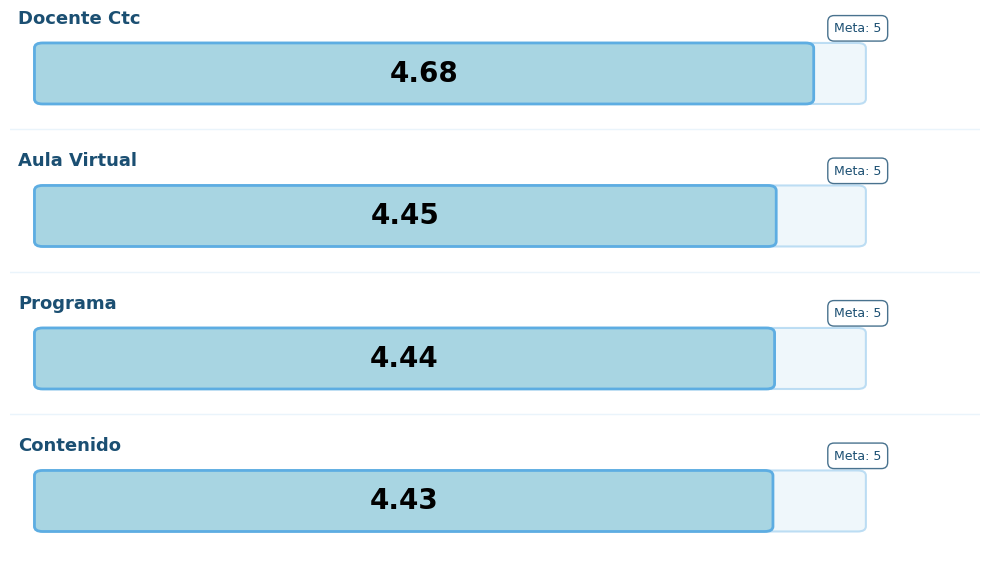

In [269]:
fig_satisfaccion_dimension=crear_gauge_barras(
    df=distri_csat,
    columna_dimension='Dimensión',
    columna_valor='Puntaje promedio',
    columna_max='Puntaje maximo',
    titulo='',
    guardar_en_biblioteca=True,
    nombre_biblioteca='gauge_satisfaccion_dimensiones',
    figsize_base=(10, 1.5)

)

(<Figure size 1200x500 with 2 Axes>, <Axes: >)

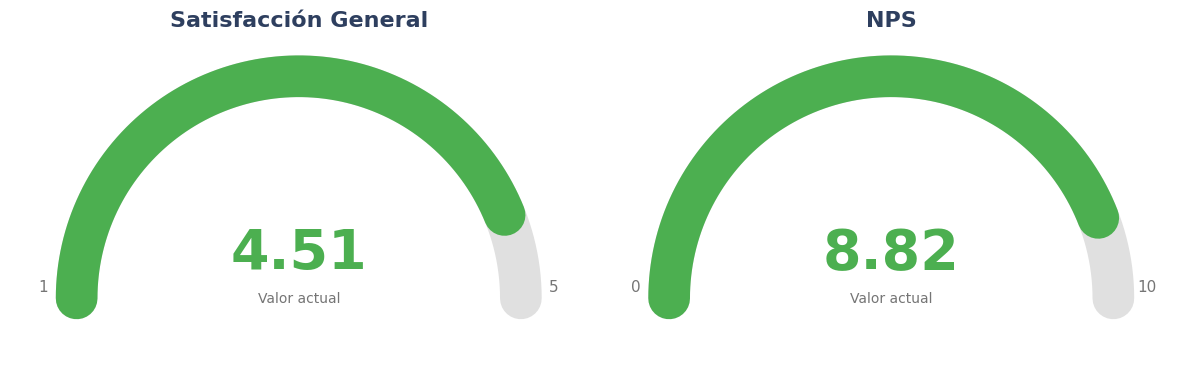

In [261]:
# Uso para crear figura combinada:
fig_satisfaccion_nps, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

crear_gauge(
    valor=satisfaccion_general,
    valor_min=1,
    valor_max=5,
    titulo='Satisfacción General',
    ax=ax1
)

crear_gauge(
    valor=nps,
    valor_min=0,
    valor_max=10,
    titulo='NPS',
    ax=ax2
)

## Profesores

In [262]:
df_satisfaccion_profesores_ie=df_satisfaccion_profesores[df_satisfaccion_profesores['tipo_profesor_respondente']=='IE']

In [263]:
satisfaccion_general_profe_ie=df_satisfaccion_profesores_ie['answer_numeric'].mean().round(2)


distri_satisfaccion_variables_IE = df_satisfaccion_profesores_ie.dropna(subset=['answer_numeric']).groupby('variable')['answer_numeric'].mean().astype(float).round(2).reset_index()
distri_satisfaccion_variables_IE.columns=['Dimensión', 'Puntaje promedio']
distri_satisfaccion_variables_IE['Puntaje maximo']=5


distri_satisfaccion_planestudio_IE = df_satisfaccion_profesores_ie.dropna(subset=['answer_numeric']).groupby('plan_estudio')['answer_numeric'].mean().astype(float).round(2).reset_index()
distri_satisfaccion_planestudio_IE.columns=['Plan de estudio', 'Puntaje promedio']
distri_satisfaccion_planestudio_IE['Puntaje maximo']=5


In [264]:
fig_satisfaccion_IE, ax1=crear_gauge(valor=satisfaccion_general_profe_ie,valor_min=1, valor_max=5, titulo='Satisfacción general de profesores IE', ax=ax1)


<Figure size 640x480 with 0 Axes>

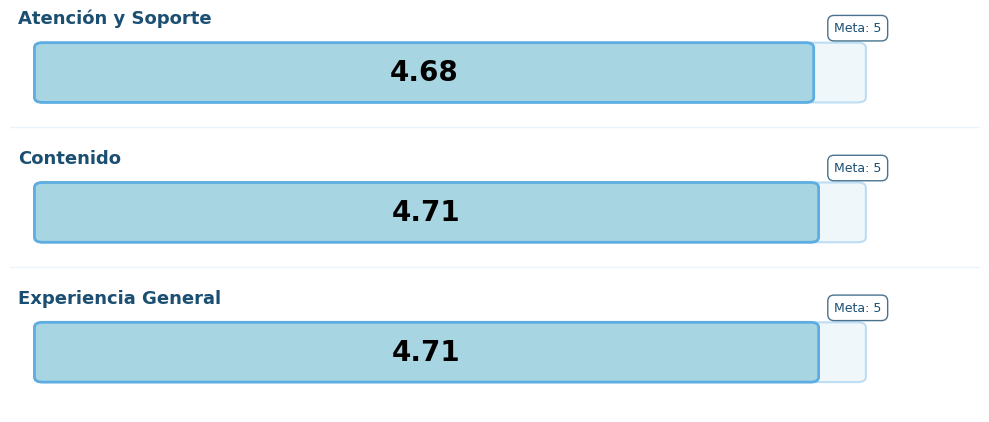

In [265]:
fig_satisfaccion_variables_IE=crear_gauge_barras(
    distri_satisfaccion_variables_IE,
    columna_dimension='Dimensión',
    columna_valor='Puntaje promedio',
    columna_max='Puntaje maximo',
    titulo='',
    guardar_en_biblioteca=True,
    nombre_biblioteca='satisfaccion_dimensiones_barras',
    figsize_base=(10, 1.5)
)

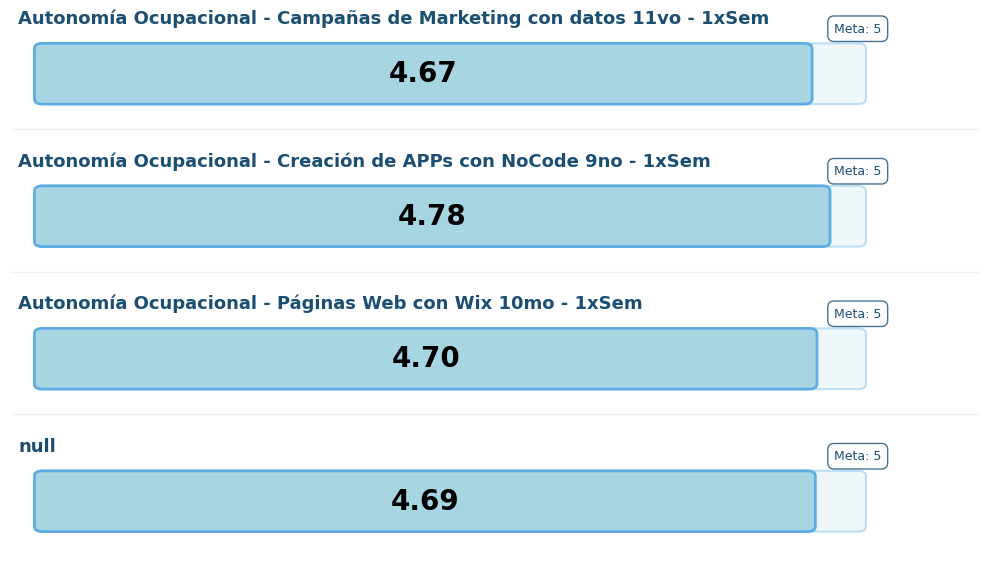

In [266]:
fig_satisfaccion_planestudio_IE=crear_gauge_barras(
    distri_satisfaccion_planestudio_IE,
    columna_dimension='Plan de estudio',
    columna_valor='Puntaje promedio',
    columna_max='Puntaje maximo',
    titulo='',
    guardar_en_biblioteca=True,
    nombre_biblioteca='satisfaccion_planestudio_barras',
    figsize_base=(10, 1.5)
)

# Medicion cruzada

# Test de informe

In [ ]:
# GENERACIÓN DE DOCUMENTO WORD CON WORD.PY

import word

# Crear el documento usando DocumentBuilder
builder = word.DocumentBuilder()

# Agregar título general del documento
builder.titulo("INFORME DE ANÁLISIS", nivel=1)

# ========================================
# INTRODUCCIÓN AL PROYECTO
# ========================================
builder.titulo("Introducción al proyecto", nivel=2)
builder.parrafo(
    "Este documento presenta un análisis exhaustivo del proyecto educativo, "
    "incluyendo información demográfica de los estudiantes, distribución por instituciones, "
    "y análisis de asistencia."
)

# Resumen general del proyecto
builder.tabla(resumen_proyecto)

# Resumen por institución educativa
if 'instituciones' in biblioteca:
    builder.titulo("Distribución por Institución Educativa", nivel=3)
    builder.tabla(resumen_IE)

# Resumen por grado
if 'grado' in biblioteca:
    builder.titulo("Distribución por Grado", nivel=3)
    builder.tabla(resumen_grado)

# ========================================
# ANÁLISIS DEMOGRÁFICO
# ========================================
builder.titulo("Análisis Demográfico", nivel=2)

# Sección: Distribución por Edad
builder.titulo("Distribución por Edad", nivel=3)
builder.parrafo(
    "El análisis por rangos etarios permite identificar los grupos de edad predominantes "
    "en el proyecto. Esta información es fundamental para ajustar contenidos, metodologías "
    "y dinámicas de aprendizaje según el nivel de desarrollo de los participantes."
)
builder.figura(fig_edad, pie="Figura 1: Distribución de estudiantes por rango de edad")
builder.tabla(dist_edad)

# Sección: Distribución por Género
builder.titulo("Distribución por Género", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de estudiantes según su género. "
    "Este indicador permite evaluar la equidad de acceso al programa y diseñar "
    "estrategias de inclusión cuando sea necesario."
)
builder.figura(fig_genero, pie="Figura 2: Distribución de estudiantes por género")
builder.tabla(dist_genero)

# Sección: Distribución por Estrato Socioeconómico
builder.titulo("Distribución por Estrato Socioeconómico", nivel=3)
builder.parrafo(
    "La distribución por estrato socioeconómico refleja el contexto económico de los estudiantes. "
    "Este dato es relevante para comprender barreras de acceso tecnológico, diseñar políticas de apoyo "
    "y evaluar el impacto social del proyecto en poblaciones vulnerables."
)
builder.figura(fig_estrato, pie="Figura 3: Distribución de estudiantes por estrato socioeconómico")
builder.tabla(dist_estrato)

# Sección: Distribución por Etnia
builder.titulo("Distribución por Etnia", nivel=3)
builder.parrafo(
    "El análisis de diversidad étnica permite comprender la composición multicultural del proyecto "
    "y diseñar estrategias pedagógicas inclusivas que respeten y valoren la diversidad cultural."
)
builder.figura(fig_etnia, pie="Figura 4: Distribución de estudiantes por etnia")
builder.tabla(dist_etnia)

# Sección: Distribución por Dispositivo
builder.titulo("Uso de Dispositivos Tecnológicos", nivel=3)
builder.parrafo(
    "El análisis del uso de dispositivos (móvil vs. escritorio) es fundamental para optimizar "
    "la experiencia de usuario y garantizar que las plataformas educativas sean accesibles "
    "desde diferentes dispositivos según las preferencias y recursos de los estudiantes."
)
builder.figura(fig_dispositivo, pie="Figura 5: Distribución de estudiantes por uso de dispositivos")
builder.tabla(dist_dispositivo)

# ========================================
# ANÁLISIS DE ASISTENCIA
# ========================================
builder.titulo("Análisis de Asistencia", nivel=2)

# Asistencia general del proyecto
asistencia_proyecto_alumno = asistencia_por(df_asistencia_alumno, 'name')
asistencia_proyecto_profe = asistencia_por(df_asistencia_profe, 'name')

builder.parrafo(
    f"El proyecto registra un porcentaje de asistencia de los alumnos del {asistencia_proyecto_alumno['% Asistencia'].iloc[0]:.1f}% "
    f"con un {asistencia_proyecto_alumno['% Falta'].iloc[0]:.1f}% de inasistencias."
    f"En tanto a los profesores la asistencia es del {asistencia_proyecto_profe['% Asistencia'].iloc[0]:.1f}% "
    f"con un {asistencia_proyecto_profe['% Falta'].iloc[0]:.1f}% de inasistencias."
)

builder.figura(fig_tarjetas_asistencias, pie="")

builder.parrafo('A lo largo del proyecto las asistencias se vieron de la siguiente forma:')

builder.figura(fig_asistencia_alumno, pie="Figura 6: Evolución de asistencia mensual de alumnos")
builder.figura(fig_asistencia_profe, pie="Figura 7: Evolución de asistencia mensual de profesores")


# Asistencia por institución
builder.titulo("Asistencia por Institución Educativa", nivel=3)
asistencia_institucion = asistencia_por(df_asistencia_alumno, 'institution').sort_values('% Asistencia', ascending=False).rename(columns={'institution':'Institución Educativa'})
builder.parrafo(
    "A continuación se presenta el porcentaje de asistencia por cada institución educativa participante:"
)
builder.tabla(asistencia_institucion)

# ========================================
# ANÁLISIS DE CANCELACIONES
# ========================================

builder.titulo("Análisis de Cancelaciones", nivel=2)
builder.parrafo(
    f"Durante el desarrollo del proyecto se programaron un total de {sesiones_programadas} sesiones, "
    f"de las cuales {sesiones_canceladas} fueron canceladas, representando un {porcentaje_cancelacion}% "
    f"de cancelaciones y un {porcentaje_dictado}% de sesiones efectivamente dictadas."
)
builder.figura(fig_tarjetas_cancelaciones, pie="")

if len(resumen_cancelaciones_por_proyecto)>1:
    builder.parrafo(
        "El siguiente análisis muestra el resumen de cancelaciones por cada proyecto educativo:"
    )
    builder.tabla(resumen_cancelaciones_por_proyecto)

builder.titulo("Principales motivos de cancelación", nivel=3)
builder.parrafo(
    "A continuación se presenta el análisis de los 10 principales motivos de cancelación de sesiones:"
)
builder.figura(fig_top_10_cancelaciones, pie="Figura 8: Top 10 motivos de cancelación de sesiones")

builder.titulo("Cancelaciones por Institución Educativa", nivel=3)
builder.parrafo(
    "El siguiente análisis muestra las instituciones educativas con mayor número de sesiones canceladas:"
)
builder.tabla(resumen_cancelaciones_IE)

# ========================================
# ANÁLISIS DE CALIFICACIONES
# ========================================

builder.titulo("Análisis de calificaciones", nivel=2)
builder.parrafo(
    "Se presenta el siguiente resumen del alcance y el desempeño de los estudiantes en los cuestionarios aplicados durante el proyecto:")
builder.figura(fig_tarjeta_cuestionarios, pie="")

builder.titulo("Distribución de Notas", nivel=3)
builder.parrafo(
    "La siguiente gráfica muestra la distribución de los estudiantes según sus rangos de notas obtenidas en los cuestionarios:"
    "Donde la nota promedio de los estudiantes aprobados fue de ## y la de estudiantes desaprobados de ##")
builder.figura(fig_distri_notas, pie="Figura 9: Distribución de alumnos por rango de notas")

builder.titulo("Desempeño por Institución Educativa", nivel=3)
builder.tabla(cuestionarios_institucion)

builder.titulo("Desempeño por Grado", nivel=3)
builder.tabla(cuestionarios_grado)

# ========================================
# ANÁLISIS DE SATISFACCION
# ========================================

builder.titulo("Análisis de Satisfacción", nivel=2)

builder.titulo("Satisfaccion de Estudiantes", nivel=3)
builder.parrafo("Se presenta el análisis de satisfacción general y por dimensiones del proyecto educativo:")
builder.figura(fig_satisfaccion_nps)

builder.titulo("Satisfacción por Dimensiones", nivel=4)
builder.figura(fig_satisfaccion_dimension, pie="Figura 10: Satisfacción por Dimensión")

builder.titulo("Satisfaccion de profesores", nivel=3)
builder.parrafo("Se presenta el análisis de satisfacción general y por dimensiones de los profesores de instituciones educativas:")
builder.figura(fig_satisfaccion_IE, pie="Figura 11: Satisfacción general de profesores IE")

builder.titulo("Satisfacción por Dimensiones", nivel=4)
builder.figura(fig_satisfaccion_variables_IE, pie="Figura 12: Satisfacción por Dimensión de profesores IE")

builder.titulo("Satisfacción por plan de estudio", nivel=4)
builder.figura(fig_satisfaccion_planestudio_IE, pie="Figura 13: Satisfacción por Plan de Estudio de profesores IE")



# ========================================
# ADJUNTOS
# ========================================
builder.salto_pagina()

builder.titulo("Documentos adjuntos", nivel=1)

builder.titulo("Motivos de Cancelación", nivel=2)
builder.parrafo(
    "A continuación se presenta el análisis de los motivos de cancelación de sesiones:"
)
builder.tabla(resumen_motivos_cancalaciones)

# Numerar todos los títulos
builder.numerar_titulos()

# Guardar el documento
ruta_salida = "informe_demografico_proyecto.docx"
builder.guardar(ruta_salida, verbose=True)


[OK] Documento guardado en: informe_demografico_proyecto.docx
[OK] Operaciones realizadas: 75
